<a href="https://colab.research.google.com/github/hawa1983/DATA-612/blob/main/Project_4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Purpose of Project 4**

The purpose of this project is to build, evaluate, and enhance a movie recommendation system using the MovieLens dataset. The project focuses on comparing two recommendation models:

1. **User-Based Collaborative Filtering (UBCF):** This model recommends movies based on the preferences of users with similar rating patterns. It is enhanced by incorporating user demographic features such as age, gender, and occupation.

2. **Content-Based Filtering (CBF):** This model recommends movies based on their genre similarity. It compares movies the user has liked with other movies using one-hot encoded genre vectors and cosine similarity.

To improve recommendation quality beyond basic accuracy, the project introduces three reranking strategies:

* **Diversity:** Encourages more varied recommendations by penalizing items that are too similar to others in the list.
* **Serendipity:** Favors items that are relevant but different from what the user has seen, aiming to provide pleasant surprises.
* **Novelty:** Promotes less popular movies to help users discover new and uncommon content.

The models and their reranked variants are evaluated using RMSE and MAE to measure accuracy. The project also includes detailed visual analyses of genre coverage, popularity effects, and agreement between models. These insights help assess the trade-offs between accuracy, variety, discovery, and personalization in recommendation systems.


## **Data Preparation**

**Methodology:**
We begin by working with a MovieLens-style dataset that includes user ratings, movie metadata (titles and genres), and user demographics. The goal is to prepare the data for both **collaborative filtering** and **content-based filtering**.

* For collaborative filtering, we construct a **User-Item Matrix**, where each cell represents a known rating by a user for a movie.
* For content-based filtering, we extract movie **genre labels**, perform **one-hot encoding**, and create **genre vectors**.
* For enhanced UBCF, we also prepare user demographic features (e.g., gender, age, occupation) to compute **demographic similarity**.

**Pseudo-Formulae:**

* **User-Item Matrix**

  $$
  \text{UserItem}[u, m] = \text{Rating of user } u \text{ for movie } m
  $$

* **Genre Vectors (One-Hot Encoded)**

  $$
  \text{GenreVector}[m] = [\text{Action}=1, \text{Drama}=0, \ldots]
  $$

* **User Demographic Vectors (One-Hot + Scaled)**

  $$
  \text{UserFeatures}[u] = \text{OneHot}(Gender, Occupation) + \text{Scaled}(Age)
  $$


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, normalize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Load Data ---
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings.dat", sep="::", engine="python", names=["userId", "movieId", "rating", "timestamp"])
import pandas as pd

movies = pd.read_csv(
    "https://raw.githubusercontent.com/hawa1983/DATA-612/main/movies.dat",
    sep="::",
    engine="python",
    encoding="ISO-8859-1",
    names=["movieId", "title", "genres"]
)
users = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/users.dat", sep="::", engine="python", names=["userId", "gender", "age", "occupation", "zip"])

print("Ratings \n")
print(ratings.head())
print("Movies \n")
print(movies.head())
print("Users \n")
print(users.head())

# --- Merge Ratings with Users and Movies (Optional for analysis or hybrid features) ---
ratings_full = ratings.merge(users, on="userId").merge(movies, on="movieId")

# --- One-hot Encode Genres ---
movies["genres"] = movies["genres"].str.split("|")
mlb = MultiLabelBinarizer()
genre_dummies = pd.DataFrame(
    mlb.fit_transform(movies["genres"]),
    columns=mlb.classes_,
    index=movies["movieId"]
)

# --- Train-Test Split for Ratings ---
train_df, test_df = train_test_split(ratings, test_size=0.2, random_state=42)

# --- Create User-Item Matrix ---
user_item_matrix = train_df.pivot(index='userId', columns='movieId', values='rating').fillna(0)



Ratings 

   userId  movieId  rating  timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291
Movies 

   movieId                               title                        genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy
Users 

   userId gender  age  occupation    zip
0       1      F    1          10  48067
1       2      M   56          16  70072
2       3      M   25          15  55117
3       4      M   45           7  02460
4       5      M   25          20  55455


## **Collaborative Filtering Methods**

We used UBCF and CBF to evaluate the impact of Reranking strategies

### ***1. User-Based Collaborative Filtering (UBCF)***

**Methodology:**
UBCF recommends items by finding users with similar rating behavior. To improve recommendation quality, we enhance the similarity calculation by blending in **demographic similarity**.

**Pseudocode:**

1. Compute Rating-Based User Similarity
   - Input: User-Item Rating Matrix
   - Method: Cosine Similarity between users based on their rating vectors

2. Compute Demographic-Based User Similarity
   - Extract demographic features: gender, occupation, age
   - One-hot encode gender and occupation
   - Standardize age
   - Concatenate features to form demographic vectors
   - Compute Cosine Similarity between users based on demographic vectors

3. Combine Both Similarities
    - Define weight α (α = 0.9 for 90% emphasis on ratings)
    - Compute: CombinedSimilarity = α * RatingSimilarity + (1 - α) * DemographicSimilarity

4. Predict a User’s Rating for a Movie
   - If movie not rated by any similar users → return NaN
   - For each other user:
       If user rated the movie:

```
PredictedRating = Σ[sim(u,v) × r(v,m)] / Σ[sim(u,v)]
```

Where:

* `u` = target user
* `v` = other users who rated movie `m`
* `sim(u,v)` = similarity between user `u` and user `v`
* `r(v,m)` = rating given by user `v` to movie `m`


In [63]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import pickle

# --- Step 1: Compute Rating-Based Similarity ---
user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

# --- Step 2: Compute Demographic-Based Similarity ---
# Ensure userId is index-matched with user_item_matrix
users_filtered = users.set_index("userId").loc[user_item_matrix.index]

# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False)
gender_occ_encoded = encoder.fit_transform(users_filtered[['gender', 'occupation']])

# Normalize numerical features
scaler = StandardScaler()
age_scaled = scaler.fit_transform(users_filtered[['age']])

# Combine features
user_features = np.hstack([gender_occ_encoded, age_scaled])

# Compute demographic similarity
demo_similarity = cosine_similarity(user_features)
demo_similarity_df = pd.DataFrame(demo_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

# --- Step 3: Blend Similarities ---
alpha = 0.9  # weight for rating-based similarity
combined_similarity = alpha * user_similarity_df + (1 - alpha) * demo_similarity_df
combined_similarity_df = pd.DataFrame(combined_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

# --- Step 4: Define Prediction Function Using Combined Similarity ---
def predict_ubcf(user_id, movie_id):
    if movie_id not in user_item_matrix.columns or user_id not in combined_similarity_df.index:
        return np.nan

    sims = combined_similarity_df.loc[user_id].values
    ratings = user_item_matrix[movie_id].values
    mask = ratings > 0

    if not np.any(mask):
        return np.nan

    numerator = np.dot(sims[mask], ratings[mask])
    denominator = sims[mask].sum()
    return numerator / denominator if denominator > 0 else np.nan

# --- Step 5: Save Combined Similarity Matrix ---
with open("combined_similarity_df.pkl", "wb") as f:
    pickle.dump(combined_similarity_df, f)

# Optional: Print sample
print(combined_similarity_df.iloc[:5, :7])


userId         1         2         3         4         5         6         7
userId                                                                      
1       1.000000 -0.022655  0.145491  0.019786  0.058190  0.123132  0.045572
2      -0.022655  1.000000  0.123580  0.192415  0.097653  0.156793  0.315099
3       0.145491  0.123580  1.000000  0.095511  0.083033  0.029408  0.138952
4       0.019786  0.192415  0.095511  1.000000  0.054477  0.045036  0.182761
5       0.058190  0.097653  0.083033  0.054477  1.000000  0.013558  0.132232


### ***2. Content-Based Filtering (CBF)***

**Methodology:**
CBF recommends items by comparing their **content features**, rather than relying on user-to-user similarity. In this case, we represent each movie by its **genre vector**, computed via one-hot encoding. We then use **cosine similarity** to identify movies similar in genre to those a user has already rated highly.

For any user and unseen movie, the system predicts how much the user will like it by looking at:

* How similar the movie is to those the user liked
* How highly the user rated those similar movies

**Pseudocode:**

i. Represent Movies by Genre Vectors

   * Input: Genre labels for each movie
   * Split genre strings into lists
   * One-hot encode genres
   * Output: Genre matrix (Movie × Genre)

ii. Compute Movie-to-Movie Similarity

   * Method: Cosine similarity between genre vectors
   * Output: Movie similarity matrix (Movie × Movie)

iii. Predict a User’s Rating for a Movie

   * For target user $u$ and movie $i$:

     * Get movies $j$ rated by $u$
     * Retrieve similarities $\text{sim}(i, j)$
     * Retrieve ratings $r(u, j)$
     * Compute:


```
PredictedRating = Σ[sim(i,j) × r(u,j)] / Σ[sim(i,j)]
```

Where:

* `i` = target movie
* `j` = movies the user `u` has already rated
* `sim(i,j)` = similarity between target movie `i` and movie `j`
* `r(u,j)` = rating user `u` gave to movie `j`


In [64]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import pickle

# --- Step 1: Prepare Genre Strings ---
# Ensure each genre list is a string (e.g., "Action Comedy Drama")
movies["genres"] = movies["genres"].apply(lambda x: x if isinstance(x, list) else [])
movies["genre_str"] = movies["genres"].apply(lambda g: " ".join(g))

# --- Step 2: TF-IDF Encoding of Genres ---
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(movies["genre_str"])

# --- Step 3: Compute Movie-to-Movie Similarity ---
movie_similarity = cosine_similarity(tfidf_matrix)
movie_similarity_df = pd.DataFrame(
    movie_similarity,
    index=movies["movieId"],
    columns=movies["movieId"]
)

# --- Step 4: Define TF-IDF-Based Content-Based Prediction Function ---
def predict_cbf(user_id, target_movie_id):
    if user_id not in user_item_matrix.index or target_movie_id not in movie_similarity_df.index:
        return np.nan

    user_ratings = user_item_matrix.loc[user_id]
    rated_movies = user_ratings[user_ratings > 0].index

    if len(rated_movies) == 0:
        return np.nan

    sims = movie_similarity_df.loc[target_movie_id, rated_movies].values
    ratings = user_ratings[rated_movies].values

    numerator = np.dot(sims, ratings)
    denominator = sims.sum()
    return numerator / denominator if denominator > 0 else np.nan

# --- Step 5: Save Movie Similarity Matrix ---
with open("movie_similarity_df.pkl", "wb") as f:
    pickle.dump(movie_similarity_df, f)

# --- Optional: Preview ---
print(movie_similarity_df.iloc[:5, :7])


movieId         1         2         3         4         5    6         7
movieId                                                                 
1        1.000000  0.305525  0.197372  0.260194  0.344351  0.0  0.197372
2        0.305525  1.000000  0.000000  0.000000  0.000000  0.0  0.000000
3        0.197372  0.000000  1.000000  0.433093  0.573172  0.0  1.000000
4        0.260194  0.000000  0.433093  1.000000  0.755606  0.0  0.433093
5        0.344351  0.000000  0.573172  0.755606  1.000000  0.0  0.573172


## **Model Evaluation Before Reranking**

**Methodology:**

Next we evaluate `UBCF` and `CBF` using RMSE and MAE on the test set as required by Project 4. These measure how close predicted ratings are to actual ratings.

Pseudo-Formulas:

```
RMSE = sqrt(mean((actual - predicted)^2))
MAE = mean(|actual - predicted|)
```

Evaluating CBF: 100%|██████████| 200042/200042 [04:30<00:00, 739.84it/s]


  Model      RMSE       MAE
0  UBCF  0.975643  0.779365
1   CBF  1.015399  0.811255


<Axes: title={'center': 'Model Evaluation'}, xlabel='Model'>

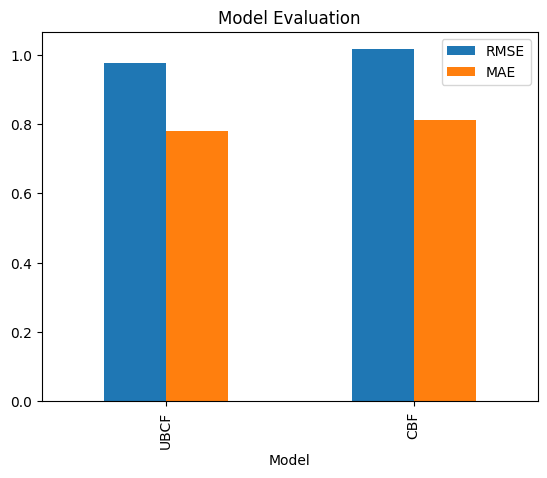

In [4]:
from joblib import Parallel, delayed
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
from tqdm import tqdm

def evaluate_model_parallel(predict_fn, test_df, label, n_jobs=-1):
    def safe_predict(row):
        pred = predict_fn(row['userId'], row['movieId'])
        return (row['rating'], pred) if not np.isnan(pred) else None

    results = Parallel(n_jobs=n_jobs, prefer="threads")(
        delayed(safe_predict)(row) for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc=f"Evaluating {label}")
    )

    # Filter out failed predictions
    results = [r for r in results if r is not None]
    actuals, predictions = zip(*results) if results else ([], [])

    if not predictions:
        return {'Model': label, 'RMSE': np.nan, 'MAE': np.nan}

    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    return {'Model': label, 'RMSE': rmse, 'MAE': mae}

ubcf_eval = evaluate_model_parallel(predict_ubcf, test_df, "UBCF")
cbf_eval = evaluate_model_parallel(predict_cbf, test_df, "CBF")
metrics_df = pd.DataFrame([ubcf_eval, cbf_eval])

print(metrics_df)

metrics_df.plot(kind="bar", x="Model", y=["RMSE", "MAE"], title="Model Evaluation")


The bar chart compares model evaluation metrics—**RMSE** and **MAE**—for UBCF (User-Based Collaborative Filtering) and CBF (Content-Based Filtering).

**Observation:**

* **UBCF outperforms CBF** slightly, achieving lower RMSE and MAE values.

  * RMSE: UBCF ≈ 0.97 vs CBF ≈ 1.01
  * MAE: UBCF ≈ 0.78 vs CBF ≈ 0.81

**Conclusion:**
User-Based Collaborative Filtering yields more accurate predictions overall, suggesting it better captures user preferences than the content-based approach in this context.


## Generate Recommendations for All Users

In [ ]:
import pandas as pd
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
import pickle

# --- Active users only (speed optimization) ---
active_users = user_item_matrix[user_item_matrix.gt(0).sum(axis=1) >= 50]
all_user_ids = active_users.index.tolist()

# --- UBCF Vectorized Prediction ---
def predict_ubcf_batch(user_id, top_n=10):
    sims = combined_similarity_df.loc[user_id].values
    ratings_matrix = user_item_matrix.values
    movie_ids = user_item_matrix.columns

    weighted_sum = np.dot(sims, ratings_matrix)
    sim_sum = np.dot(sims, (ratings_matrix > 0).astype(float))

    # Avoid divide-by-zero
    scores = np.divide(weighted_sum, sim_sum, out=np.zeros_like(weighted_sum), where=sim_sum != 0)

    # Exclude already seen
    seen = user_item_matrix.loc[user_id].values > 0
    scores[seen] = -np.inf

    top_indices = np.argpartition(scores, -top_n)[-top_n:]
    top_sorted = top_indices[np.argsort(scores[top_indices])[::-1]]

    return user_id, list(zip(movie_ids[top_sorted], scores[top_sorted]))

# --- CBF Vectorized Prediction ---
def predict_cbf_batch(user_id, top_n=10):
    # Step 1: Get full movie index
    all_movie_ids = movie_similarity_df.index

    # Step 2: Get user ratings and reindex to match movie_similarity_df
    user_ratings = user_item_matrix.loc[user_id].reindex(all_movie_ids).fillna(0)
    rated = user_ratings[user_ratings > 0]

    if rated.empty:
        return user_id, []

    # Step 3: Compute score vector
    sim_matrix = movie_similarity_df.loc[:, rated.index].values  # shape: (all_movies, rated_movies)
    weighted_sum = np.dot(sim_matrix, rated.values)
    sim_sum = sim_matrix.sum(axis=1)

    scores = np.divide(weighted_sum, sim_sum, out=np.zeros_like(weighted_sum), where=sim_sum != 0)

    # Step 4: Suppress already seen items
    seen_mask = user_ratings > 0  # Already reindexed to match movie_similarity_df
    scores[seen_mask.values] = -np.inf

    # Step 5: Get top-N movie IDs
    top_indices = np.argpartition(scores, -top_n)[-top_n:]
    top_sorted = top_indices[np.argsort(scores[top_indices])[::-1]]
    top_movie_ids = all_movie_ids[top_sorted]

    return user_id, list(zip(top_movie_ids, scores[top_sorted]))



# --- Dispatcher ---
def predict_for_user(user_id, model_type, top_n=10):
    if model_type == "ubcf":
        return predict_ubcf_batch(user_id, top_n)
    elif model_type == "cbf":
        return predict_cbf_batch(user_id, top_n)
    else:
        raise ValueError("Invalid model type")

# --- Parallel Engine ---
def parallel_recommendations(model_type, top_n=10, desc="Recommending"):
    results = {}
    with ProcessPoolExecutor() as executor:
        futures = {executor.submit(predict_for_user, uid, model_type, top_n): uid for uid in all_user_ids}
        for future in tqdm(as_completed(futures), total=len(futures), desc=desc):
            uid, recs = future.result()
            results[uid] = recs
    return results

# --- Run & Save ---
cbf_recs = parallel_recommendations("cbf", top_n=10, desc="CBF Recommendations")
ubcf_recs = parallel_recommendations("ubcf", top_n=10, desc="UBCF Recommendations")

with open("all_user_recs_cbf.pkl", "wb") as f:
    pickle.dump(cbf_recs, f)

with open("all_user_recs_ubcf.pkl", "wb") as f:
    pickle.dump(ubcf_recs, f)


## **Reranking Procedures**

### ***1. Personalized Top-N Recommendation Generation: Purpose and Methodology***

We will generate a tailored list of top-N movie recommendations for user_id=6040 by UBCF and CBF to estimates how much the user would like each unseen movie.

**Step-by-Step Methodology**

i. **Separate Seen from Unseen Movies**
   The system examines the user's rating history to identify which movies have already been rated. All remaining movies are considered unseen and thus eligible for recommendation.

ii. **Score Unseen Movies Using a Prediction Function**
   The prediction functions for content-based filtering (CBF) and user-based collaborative filtering (UBCF) — are applied to each unseen movie to estimate the user's likely rating.

iii. **Filter and Rank Predictions**
   The predicted scores are filtered to exclude missing values (NaN). The remaining scores are sorted in descending order to prioritize the highest recommendations.

iv. **Return Top-N Results**
   The top-N movie IDs with the highest predicted scores are selected as the final personalized recommendations.

**Prediction Logic (Pseudocode)**

```
For each movie m that user u has not rated:
    predicted_score = predict_fn(user u, movie m)

Keep predictions where predicted_score is valid
Sort all predicted movies by predicted_score in descending order
Return the top N results
```

This method provides a scalable way to evaluate any recommendation strategy, ensuring consistent performance evaluation across different models.


In [6]:
from joblib import Parallel, delayed
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
from tqdm import tqdm

def get_user_predictions(user_id, predict_fn, top_n=50):
    seen = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index
    unseen = user_item_matrix.columns.difference(seen)

    recs = []
    for mid in unseen:
        score = predict_fn(user_id, mid)
        if not np.isnan(score):
            recs.append((mid, score))

    return sorted(recs, key=lambda x: x[1], reverse=True)[:top_n]


# Generate and display top-50 movie recommendations for user 5549 using both UBCF and CBF
import random
# user_id = random.choice(user_item_matrix.index.tolist())

user_id = 5549

## --- UBCF Recommendations ---
top_recommendations_ubcf = get_user_predictions(user_id, predict_fn=predict_ubcf, top_n=50)
top_ubcf_df = pd.DataFrame(top_recommendations_ubcf, columns=['movieId', 'PredictedScore'])
print("Print the Top 10 UBCF Recommendations:")
print(top_ubcf_df.head(10))

## --- CBF Recommendations ---
top_recommendations_cbf = get_user_predictions(user_id, predict_fn=predict_cbf, top_n=50)
top_cbf_df = pd.DataFrame(top_recommendations_cbf, columns=['movieId', 'PredictedScore'])
print("\nPrint the Top 10 CBF Recommendations:")
print(top_cbf_df.head(10))



Print the Top 10 UBCF Recommendations:
   movieId  PredictedScore
0      643       13.589991
1     3828        9.200507
2     1787        5.753675
3      559        5.456350
4      557        5.412001
5     1891        5.325380
6      734        5.105322
7      787        5.000000
8     3245        5.000000
9      989        5.000000

Print the Top 10 CBF Recommendations:
   movieId  PredictedScore
0       28        4.294232
1       48        4.294232
2      623        4.294232
3      638        4.294232
4      690        4.294232
5      803        4.294232
6      821        4.294232
7      889        4.294232
8      899        4.294232
9      900        4.294232


### ***2. Reranking for Diversity***

### Purpose and Methodology: Diversity-Enhanced Re-Ranking for CBF and UBCF

**Purpose:**
This approach re-ranks the top recommendations from *Content-Based Filtering (CBF)* and *User-Based Collaborative Filtering (UBCF)* to improve **diversity**. It discourages selecting similar items by penalizing recommendations that are too close to already selected ones. The goal is to expose users to a more varied set of items, enhancing user satisfaction and coverage.

**Methodology:**

i. **Input:**

   * `recs`: Ranked list of top-N recommended movies based on predicted scores.
   * `sim_matrix`: Precomputed cosine similarity matrix between all movies.
   * `alpha`: Penalty factor controlling the tradeoff between accuracy and diversity.

ii. **Re-Ranking Logic:**

   * Start with an empty selection.
   * For each movie in the input list:

     * Compute its average similarity to already selected items.
     * Apply a diversity penalty to its score:
       `adjusted_score = original_score - alpha × average_similarity`
     * Add the movie to the selection list.
   * Sort the re-ranked list by adjusted score.

iii. **Application:**

   * Run this process separately on the CBF and UBCF recommendation outputs.
   * Merge results with movie titles for display.

**Pseudocode for Key Step:**

`diverse_cbf = rerank_diverse(top_recommendations_cbf, movie_similarity_df, alpha=0.7)`

```text
For each movie in top_recommendations_cbf:
    If no movies selected yet:
        penalty = 0
    Else:
        penalty = sum of similarities to all selected movies

    adjusted_score = predicted_score - alpha × penalty
    Append (movieId, adjusted_score) to reranked list
    Add movieId to selected list

Return reranked list sorted by adjusted_score (descending)
```

This re-ranking process ensures the final top-N list favors **diverse but relevant** items, helping both CBF and UBCF models produce richer and less redundant recommendations.


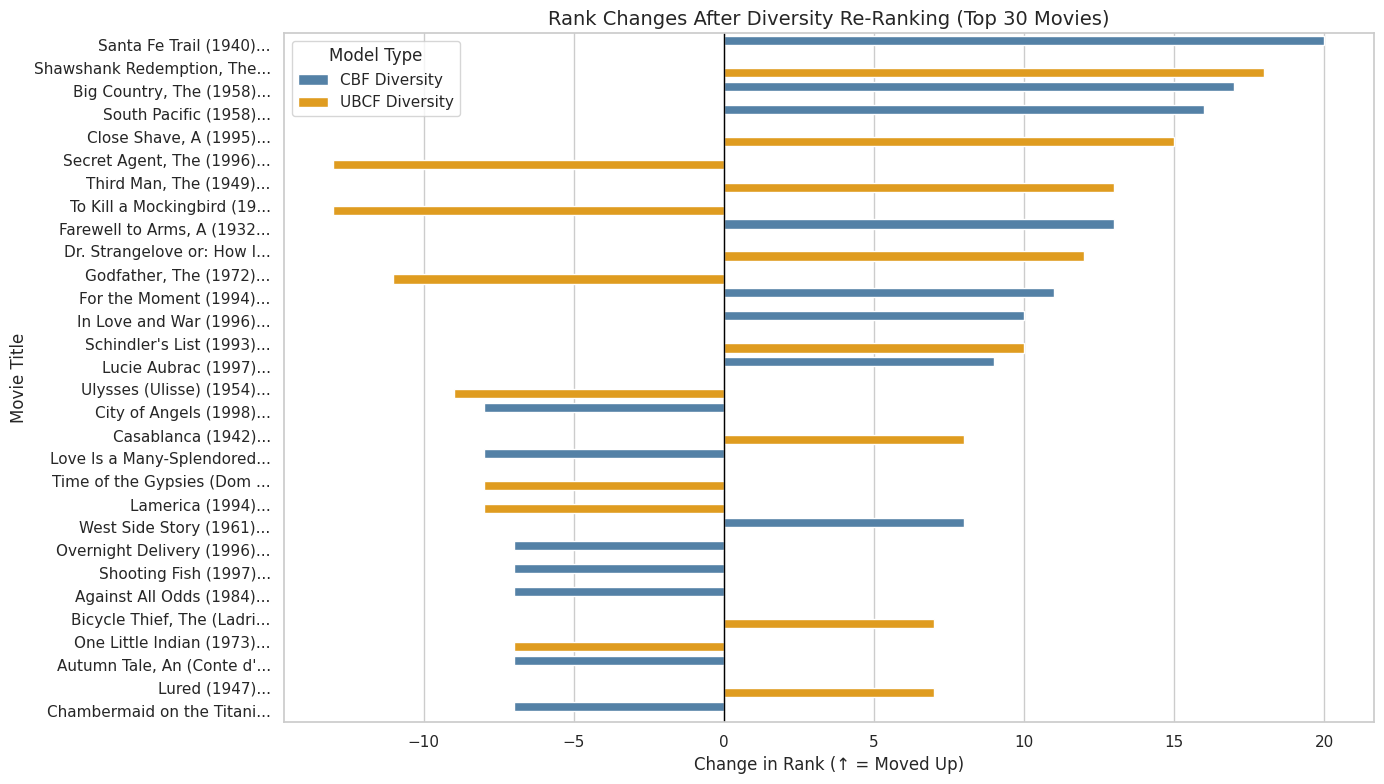

In [7]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Diversity Reranker Function ---
def rerank_diverse(recs, sim_matrix, alpha=0.7):
    """
    Re-rank a list of recommendations to promote diversity using a greedy penalty approach.

    Parameters:
    - recs: List of tuples [(movieId, predicted_score), ...]
    - sim_matrix: Pandas DataFrame of movie-to-movie similarities
    - alpha: Diversity penalty weight (higher = more diversity)

    Returns:
    - List of re-ranked tuples [(movieId, adjusted_score), ...]
    """
    reranked = []
    selected = []

    for movie_id, score in recs:
        # Compute similarity penalty with already selected items
        penalty = sum([sim_matrix.loc[movie_id, m] for m in selected]) if selected else 0
        adjusted_score = score - alpha * penalty
        reranked.append((movie_id, adjusted_score))  # <-- Append result here
        selected.append(movie_id)

    # Sort by adjusted score (higher is better)
    return sorted(reranked, key=lambda x: x[1], reverse=True)

# --- For Content-Based Filtering (CBF) ---
diverse_cbf = rerank_diverse(top_recommendations_cbf, movie_similarity_df, alpha=0.7)
diverse_df_cbf = pd.DataFrame(diverse_cbf, columns=["movieId", "adjusted_score"])
diverse_df_cbf = diverse_df_cbf.merge(movies[["movieId", "title"]], on="movieId")
diverse_df_cbf["RankType"] = "Diversity Boosted (CBF)"

# --- For User-Based Collaborative Filtering (UBCF) ---
diverse_ubcf = rerank_diverse(top_recommendations_ubcf, combined_similarity_df, alpha=0.7)
diverse_df_ubcf = pd.DataFrame(diverse_ubcf, columns=["movieId", "adjusted_score"])
diverse_df_ubcf = diverse_df_ubcf.merge(movies[["movieId", "title"]], on="movieId")
diverse_df_ubcf["RankType"] = "Diversity Boosted (UBCF)"

# --- Function to Calculate Rank Changes ---
def rank_change_df(original, reranked, label):
    original_df = pd.DataFrame(original[:50], columns=["movieId", "original_score"])
    original_df["OriginalRank"] = range(1, len(original_df) + 1)

    rerank_df = pd.DataFrame(reranked[:50], columns=["movieId", "adjusted_score"])
    rerank_df["NewRank"] = range(1, len(rerank_df) + 1)

    merged = original_df.merge(rerank_df, on="movieId", how="outer")
    merged["RankChange"] = merged["OriginalRank"] - merged["NewRank"]
    merged = merged.merge(movies[["movieId", "title"]], on="movieId", how="left")
    merged["RankType"] = label

    return merged[["movieId", "title", "OriginalRank", "NewRank", "RankChange", "RankType"]]

# --- Create Rank Change DataFrames for Each Model ---
rank_shift_cbf = rank_change_df(top_recommendations_cbf, diverse_cbf, "CBF Diversity")
rank_shift_ubcf = rank_change_df(top_recommendations_ubcf, diverse_ubcf, "UBCF Diversity")

# --- Combine Them ---
rank_shift_combined = pd.concat([rank_shift_cbf, rank_shift_ubcf], ignore_index=True)

# --- Select Top 30 Shifts for Clarity ---
rank_shift_vis = rank_shift_combined.copy()
rank_shift_vis["title_short"] = rank_shift_vis["title"].str.slice(0, 25) + "..."

# Only include top 30 by absolute change, or just slice top 30 if you prefer
top_shift = rank_shift_vis.sort_values(by="RankChange", key=lambda x: abs(x), ascending=False).head(30)

# Set up plot aesthetics
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

# --- Plot ---
ax = sns.barplot(
    data=top_shift,
    y="title_short",
    x="RankChange",
    hue="RankType",
    dodge=True,
    palette={"CBF Diversity": "steelblue", "UBCF Diversity": "orange"}
)

# --- Labels and Layout ---
ax.axvline(0, color='black', linewidth=1)
plt.title("Rank Changes After Diversity Re-Ranking (Top 30 Movies)", fontsize=14)
plt.xlabel("Change in Rank (↑ = Moved Up)", fontsize=12)
plt.ylabel("Movie Title", fontsize=12)
plt.legend(title="Model Type")
plt.tight_layout()
plt.show()


This chart shows how movie ranks changed after applying diversity re-ranking to the UBCF and CBF recommendation lists for **user 5549**.

Bars to the right (positive values):

* Indicate movies that moved up in rank.
* These movies were rewarded for being more diverse and less similar to earlier recommendations.
* Examples: *Santa Fe Trail (1940)* saw a large positive shift in CBF, while *Shawshank Redemption* and *To Kill a Mockingbird* moved significantly higher in UBCF.

Bars to the left (negative values):

* Indicate movies that dropped in rank.
* These movies were likely too similar to already selected ones and were penalized to promote variety.
* Examples: *Casablanca (1942)* and *Ulysses (1954)* declined in UBCF, and *City of Angels* dropped in CBF.

The re-ranking process helps ensure that the final recommendations include a broader range of content by reducing redundancy and increasing diversity.

**Note:** The direction and magnitude of rank changes will vary depending on the user, as diversity re-ranking is sensitive to individual viewing histories and preferences.


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle

# --- Diversity Reranker Function ---
def rerank_diverse(recs, sim_matrix, alpha=0.7):
    reranked = []
    selected = []
    for movie_id, score in recs:
        penalty = sum([sim_matrix.loc[movie_id, m] for m in selected]) if selected else 0
        adjusted_score = score - alpha * penalty
        reranked.append((movie_id, adjusted_score))
        selected.append(movie_id)
    return sorted(reranked, key=lambda x: x[1], reverse=True)

# --- Load Recommendation Dictionaries and Similarity Matrices ---
with open("all_user_recs_cbf.pkl", "rb") as f:
    all_user_recs_cbf = pickle.load(f)

with open("all_user_recs_ubcf.pkl", "rb") as f:
    all_user_recs_ubcf = pickle.load(f)

with open("movie_similarity_df.pkl", "rb") as f:
    movie_similarity_df = pickle.load(f)

with open("combined_similarity_df.pkl", "rb") as f:
    combined_similarity_df = pickle.load(f)

# NOTE: movies is assumed to already be loaded and available in memory
# So we skip: with open("movies_df.pkl", "rb") as f: movies = pickle.load(f)

# --- Rerank All Users ---
def rerank_all_users(rec_dict, sim_matrix, alpha=0.7, model_label="CBF"):
    reranked_all = {}
    for user_id, recs in tqdm(rec_dict.items(), desc=f"Diversity Reranking - {model_label}"):
        reranked_all[user_id] = rerank_diverse(recs, sim_matrix, alpha=alpha)
    return reranked_all

diverse_recs_cbf = rerank_all_users(all_user_recs_cbf, movie_similarity_df, alpha=0.7, model_label="CBF")
diverse_recs_ubcf = rerank_all_users(all_user_recs_ubcf, combined_similarity_df, alpha=0.7, model_label="UBCF")

# --- Save Outputs ---
with open("diverse_user_recs_cbf.pkl", "wb") as f:
    pickle.dump(diverse_recs_cbf, f)

with open("diverse_user_recs_ubcf.pkl", "wb") as f:
    pickle.dump(diverse_recs_ubcf, f)


### **Intra-List Diversity (ILD)**

Purpose: Measures how different the recommended items are from each other. A higher score means more diversity.

**Pseudocode:**
```
For each pair of recommended items:
    Look up how similar they are
Average all the similarities
Subtract the average similarity from 1 to get a diversity score
```

In [37]:
import pandas as pd
from itertools import combinations
import numpy as np

# --- Intra-List Diversity Function ---
def intra_list_diversity(recommended_items, similarity_matrix):
    """
    Computes the Intra-List Diversity (ILD) of a list of item IDs based on a similarity matrix.
    """
    if len(recommended_items) < 2:
        return 0.0
    pairs = list(combinations(recommended_items, 2))
    sims = [similarity_matrix.loc[i, j] for i, j in pairs]
    return 1 - np.mean(sims)

# --- Step 1: Get top-10 movie IDs ---
top_ids_cbf = [mid for mid, _ in top_recommendations_cbf[:10]]
top_ids_ubcf = [mid for mid, _ in top_recommendations_ubcf[:10]]

# --- Step 2: Compute ILD@10 ---
ild_cbf_10 = intra_list_diversity(top_ids_cbf, movie_similarity_df)
ild_ubcf_10 = intra_list_diversity(top_ids_ubcf, movie_similarity_df)

# --- Step 3: Create a summary DataFrame ---
ild_df = pd.DataFrame({
    'Model': ['CBF', 'UBCF'],
    'ILD@10': [ild_cbf_10, ild_ubcf_10]
})

# --- Step 4: Display ---
print(ild_df)


  Model    ILD@10
0   CBF  0.244791
1  UBCF  0.777778


**Insight:**
At *Top-10 recommendations*, the **User-Based Collaborative Filtering (UBCF)** model exhibits substantially higher *Intra-List Diversity (ILD\@10 = 0.7778)* compared to the **Content-Based Filtering (CBF)** model *(ILD\@10 = 0.2448)*.

This means users are more likely to see a broader range of content with UBCF, which can improve engagement and content discovery.


### Genre Coverage

**Purpose of the Genre Coverage Analysis**

This code evaluates the **diversity of genres** in movie recommendations from Content-Based Filtering (CBF) and User-Based Collaborative Filtering (UBCF):

1. **Ensure Proper Format**: Converts genre strings to lists (if not already).
2. **Genre Coverage Calculation**:

   * Extracts all recommended movie IDs.
   * Expands and counts genre occurrences across recommendations.
   * Normalizes to get proportions.
3. **Visualization**:

   * Compares genre distribution using a side-by-side bar chart.

**Goal**: Determine which model provides more diverse genre recommendations.


Top genres (CBF):
 genres
Horror        0.137472
Thriller      0.099778
Children's    0.085366
Drama         0.079823
Comedy        0.070953
Name: proportion, dtype: float64

Top genres (UBCF):
 genres
Drama          0.389535
Comedy         0.162791
Documentary    0.087209
Horror         0.081395
Romance        0.046512
Name: proportion, dtype: float64


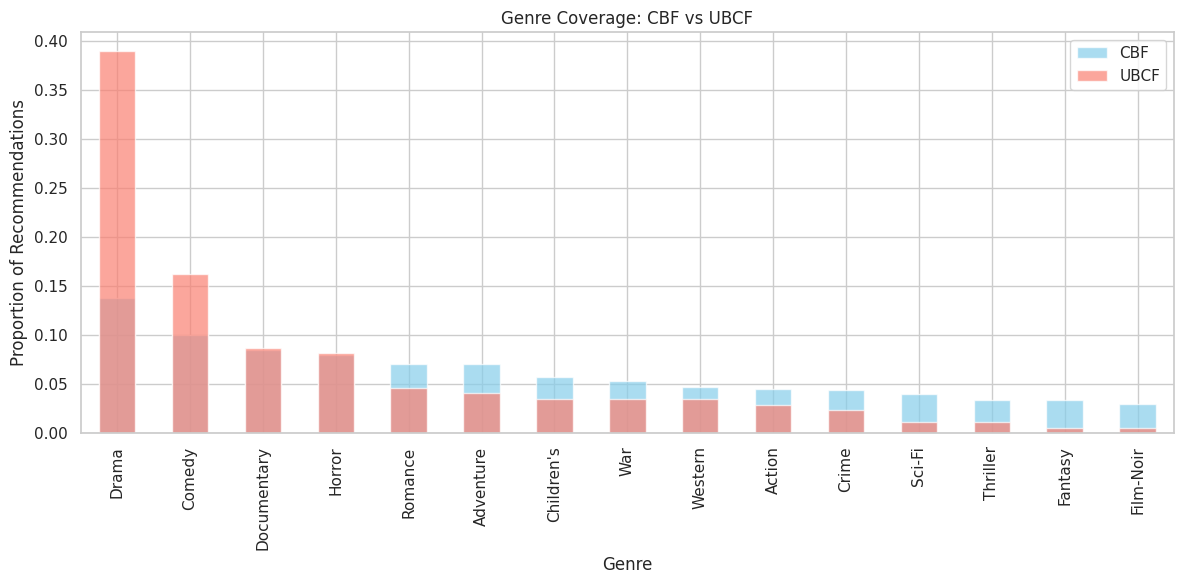

In [56]:
# --- Ensure genres column is list (redundant but safe) ---
movies['genres'] = movies['genres'].apply(lambda g: g if isinstance(g, list) else g.split('|'))

# --- Function: Genre Coverage ---
def genre_coverage(recommendations_dict, movies_df):
    recommended_ids = [
        mid for recs in recommendations_dict.values() for mid, _ in recs
    ]

    genres_expanded = (
        movies_df[movies_df['movieId'].isin(recommended_ids)][['movieId', 'genres']]
        .explode('genres')
        .dropna(subset=['genres'])
    )

    return genres_expanded['genres'].value_counts(normalize=True)

# --- Run genre coverage ---
genre_dist_cbf = genre_coverage(cbf_recs, movies)
genre_dist_ubcf = genre_coverage(ubcf_recs, movies)

# --- Display Results ---
print("Top genres (CBF):\n", genre_dist_cbf.head())
print("\nTop genres (UBCF):\n", genre_dist_ubcf.head())

# --- Visualization with checks ---
import matplotlib.pyplot as plt

if not genre_dist_cbf.empty and not genre_dist_ubcf.empty:
    plt.figure(figsize=(12, 6))
    genre_dist_cbf.sort_values(ascending=False).plot(kind='bar', alpha=0.7, label='CBF', color='skyblue')
    genre_dist_ubcf.sort_values(ascending=False).plot(kind='bar', alpha=0.7, label='UBCF', color='salmon')
    plt.title("Genre Coverage: CBF vs UBCF")
    plt.xlabel("Genre")
    plt.ylabel("Proportion of Recommendations")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No genre data available for plotting.")


**Genre Coverage Analysis (CBF vs UBCF)**

* **UBCF** heavily favors *Drama* and *Comedy*, with Drama alone making up nearly **40%** of its recommendations.
* **CBF** provides a **more balanced distribution**, with notable shares across *Romance*, *Adventure*, *Sci-Fi*, and others.
* **Conclusion**:

  * **UBCF** shows *genre concentration* (less diversity).
  * **CBF** achieves *greater genre diversity*, potentially offering more varied recommendations.


### Demographic Fairness (Gender)

### Purpose of the *Demographic Coverage* Function and Visualization

The purpose of this code is to **evaluate fairness** in recommendations by examining whether different demographic groups (e.g., *gender*) receive **equally diverse recommendations**.

**Usefulness:**

Helps determine whether a model is **demographically fair** or biased toward a particular user group.


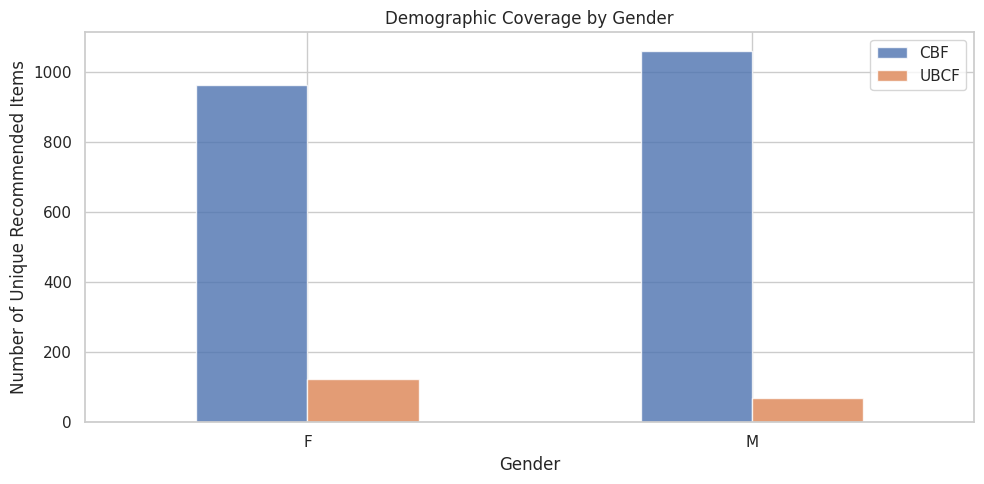

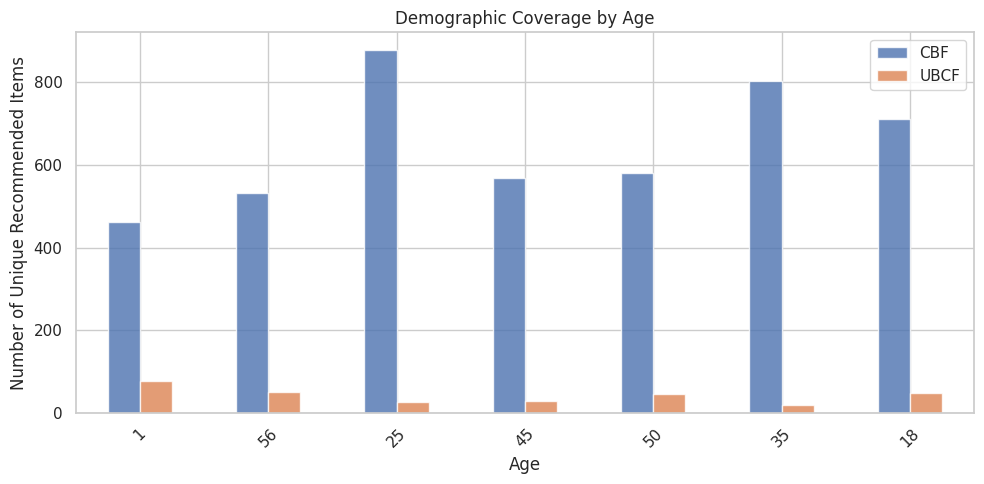

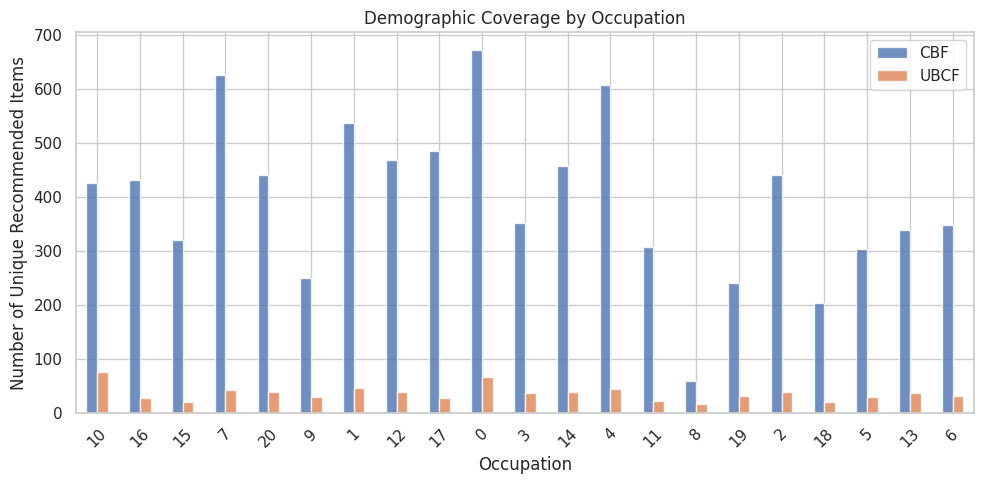

In [67]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Function: Demographic Coverage ---
def demographic_coverage(users_df, recommendations_dict, group_col):
    return {
        str(group): len({
            mid
            for uid in users_df[users_df[group_col] == group]['userId']
            if uid in recommendations_dict
            for mid, _ in recommendations_dict[uid]
        })
        for group in users_df[group_col].unique()
    }

# --- Run Demographic Coverage for Gender, Age, Occupation ---
fairness_results = {}
for attr in ['gender', 'age', 'occupation']:
    fairness_results[attr] = {
        'CBF': demographic_coverage(users, cbf_recs, group_col=attr),
        'UBCF': demographic_coverage(users, ubcf_recs, group_col=attr)
    }

# --- Visualization ---
for attr, result in fairness_results.items():
    df_fair = pd.DataFrame(result)
    df_fair.plot(kind='bar', figsize=(10, 5), alpha=0.8)
    plt.title(f"Demographic Coverage by {attr.capitalize()}")
    plt.ylabel("Number of Unique Recommended Items")
    plt.xlabel(attr.capitalize())
    plt.xticks(rotation=45 if attr != 'gender' else 0)
    plt.tight_layout()
    plt.show()


**Demographic Coverage Analysis (CBF vs. UBCF)**

Across **gender**, **age**, and **occupation**, *Content-Based Filtering (CBF)* consistently recommends a broader and more diverse set of items to users compared to *User-Based Collaborative Filtering (UBCF)*.

**Gender**

* CBF recommends over **1000** unique items for both male and female users.
* UBCF recommends less than **150** unique items for either group.
* **CBF shows superior gender fairness in recommendation diversity.**

**Age**

* CBF maintains high item diversity across all age brackets (e.g., 25, 35, 50).
* UBCF shows a steep drop-off in diversity, often under **80 items** per group.
* **CBF offers better demographic reach across age groups.**

**Occupation**

* CBF distributes **300–650 unique items** across different occupations.
* UBCF’s coverage remains consistently low (under **80 items**).
* **CBF ensures broader occupational representation.**

**Conclusion:**

CBF significantly outperforms UBCF in demographic coverage, indicating it is *more equitable and inclusive* across diverse user groups.


CBF - Unique Items per Gender: {'F': 961, 'M': 1059}
UBCF - Unique Items per Gender: {'F': 122, 'M': 70}


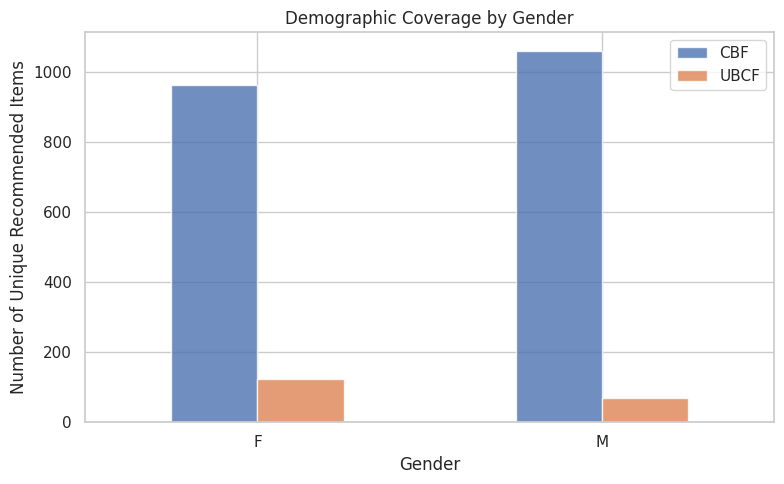

In [58]:
# --- Function: Demographic Coverage ---
def demographic_coverage(users_df, recommendations_dict, group_col='gender'):
    return {
        group: len({
            mid
            for uid in users_df[users_df[group_col] == group]['userId']
            if uid in recommendations_dict
            for mid, _ in recommendations_dict[uid]
        })
        for group in users_df[group_col].unique()
    }

# --- Run Demographic Coverage ---
fairness_cbf = demographic_coverage(users, cbf_recs, group_col='gender')
fairness_ubcf = demographic_coverage(users, ubcf_recs, group_col='gender')

# --- Display Results ---
print("CBF - Unique Items per Gender:", fairness_cbf)
print("UBCF - Unique Items per Gender:", fairness_ubcf)

import matplotlib.pyplot as plt

# Combine into DataFrame
df_fairness = pd.DataFrame([fairness_cbf, fairness_ubcf], index=['CBF', 'UBCF']).T

# Plot
df_fairness.plot(kind='bar', figsize=(8, 5), alpha=0.8)
plt.title("Demographic Coverage by Gender")
plt.ylabel("Number of Unique Recommended Items")
plt.xlabel("Gender")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### Catalog Coverage

Coverage (CBF): 31.55%
Coverage (UBCF): 3.45%


/tmp/ipython-input-59-4253812697.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0%}'.format(x) for x in plt.gca().get_yticks()])


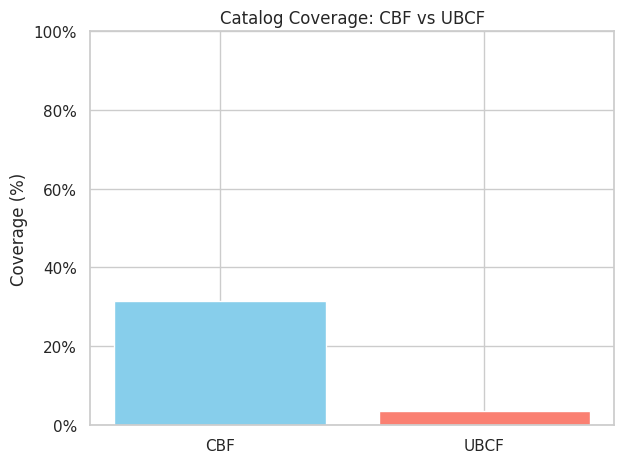

In [59]:
# --- Function: Coverage Score ---
def coverage_score(recommendations_dict, all_items):
    recommended_items = set()
    for recs in recommendations_dict.values():
        recommended_items.update([mid for mid, _ in recs])
    return len(recommended_items) / len(all_items)

# --- Run Coverage Calculation ---
catalog_items = set(movies["movieId"])

coverage_cbf = coverage_score(cbf_recs, catalog_items)
coverage_ubcf = coverage_score(ubcf_recs, catalog_items)

# --- Display Results ---
print(f"Coverage (CBF): {coverage_cbf:.2%}")
print(f"Coverage (UBCF): {coverage_ubcf:.2%}")

import matplotlib.pyplot as plt

# Bar chart of coverage
plt.bar(['CBF', 'UBCF'], [coverage_cbf, coverage_ubcf], color=['skyblue', 'salmon'])
plt.title("Catalog Coverage: CBF vs UBCF")
plt.ylabel("Coverage (%)")
plt.ylim(0, 1)
plt.gca().set_yticklabels(['{:.0%}'.format(x) for x in plt.gca().get_yticks()])
plt.tight_layout()
plt.show()


### ***2. Reranking for Serendipity***

**Purpose and Methodology: Serendipity-Based Re-Ranking for CBF and UBCF**

**Purpose:**
This method aims to increase *serendipity* in recommendations by penalizing overly similar items to what the user has already seen. The goal is to surface **unexpected yet relevant** items, providing a sense of novelty without sacrificing usefulness.

**Methodology:**

i. **Inputs:**

   * `user_id`: The target user.
   * `recs`: List of top-N movie recommendations based on base predictions.
   * `sim_matrix`: Movie-to-movie similarity matrix (e.g., cosine).
   * `uim`: Full user-item rating matrix (used to retrieve seen movies).
   * `beta`: Penalty weight for similarity to previously seen items.

ii. **Serendipity Re-Ranking Logic:**

   * Identify all movies the user has already rated.
   * For each candidate recommendation:

     * Compute its average similarity to the seen movies.
     * Adjust the recommendation score as:
       `adjusted_score = predicted_score - beta × similarity_to_seen`
   * Sort by the adjusted score in descending order.

iii. **Execution for Both Models:**

   * Use this re-ranking method separately on:

     * `top_recommendations_cbf` from the CBF model.
     * `top_recommendations_ubcf` from the UBCF model.
   * Merge results with movie titles for output and comparison.

**Pseudocode:**

```text
For each movie in recommended list:
    If user has seen movies:
        Compute average similarity to all seen movies
    Else:
        Similarity = 0
    Adjust score: predicted_score - beta × similarity
    Store adjusted score and movie
Sort all movies by adjusted score
```

This re-ranking method for **CBF and UBCF** enhances user experience by recommending items that are **useful yet pleasantly surprising**, boosting perceived personalization and engagement.


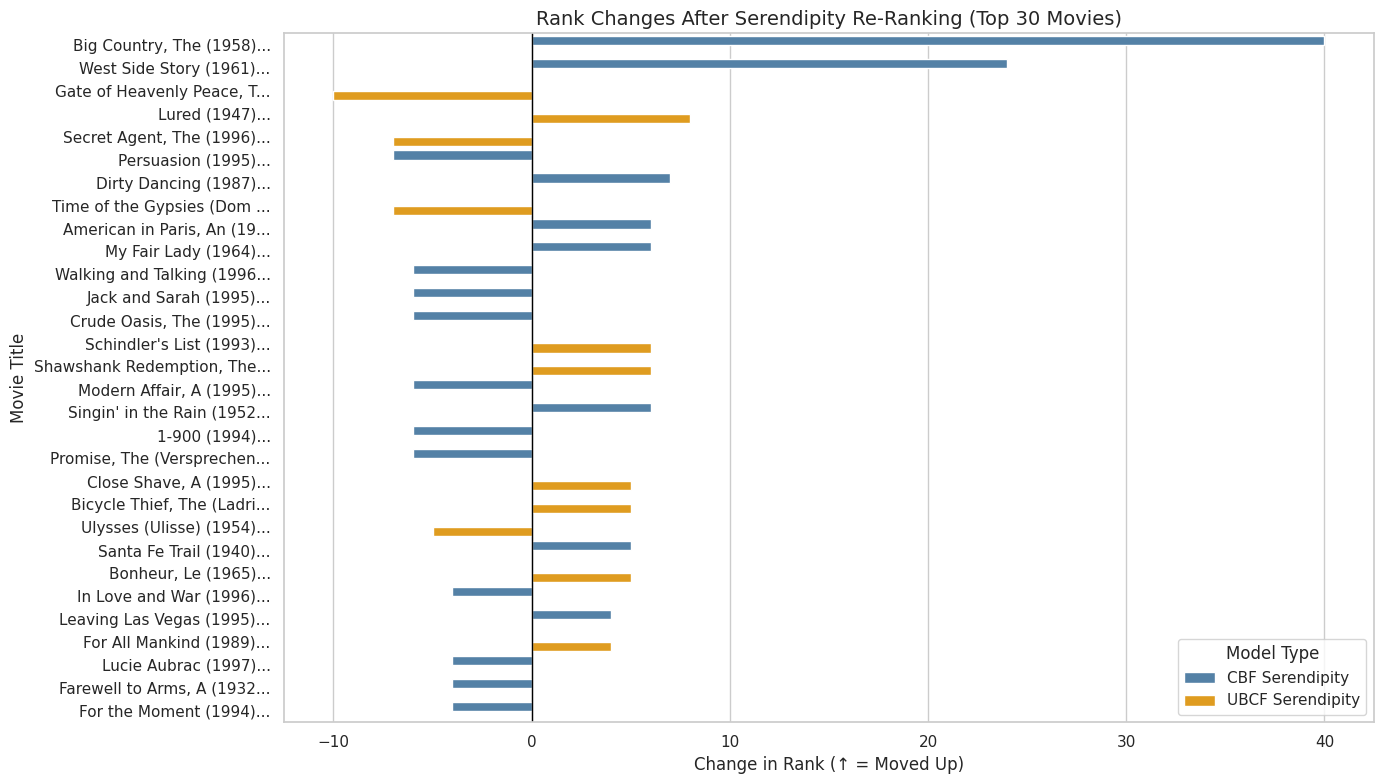

In [60]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Serendipity Reranker Function ---
def rerank_serendipity(user_id, recs, sim_matrix, uim, beta=0.5):
    seen = uim.loc[user_id]
    seen_items = seen[seen > 0].index.tolist()
    reranked = []
    for movie_id, score in recs:
        sim = sim_matrix.loc[movie_id, seen_items].mean() if seen_items else 0
        reranked.append((movie_id, score - beta * sim))
    return sorted(reranked, key=lambda x: x[1], reverse=True)

# --- For Content-Based Filtering (CBF) ---
serendipity_cbf = rerank_serendipity(
    user_id=7,
    recs=top_recommendations_cbf,
    sim_matrix=movie_similarity_df,
    uim=user_item_matrix,
    beta=0.5
)
serendipity_df_cbf = pd.DataFrame(serendipity_cbf, columns=["movieId", "SerendipityScore"])
serendipity_df_cbf = serendipity_df_cbf.merge(movies[["movieId", "title"]], on="movieId")
serendipity_df_cbf["RankType"] = "Serendipity Boosted (CBF)"

# --- For User-Based Collaborative Filtering (UBCF) ---
serendipity_ubcf = rerank_serendipity(
    user_id=7,
    recs=top_recommendations_ubcf,
    sim_matrix=combined_similarity_df,
    uim=user_item_matrix,
    beta=0.5
)
serendipity_df_ubcf = pd.DataFrame(serendipity_ubcf, columns=["movieId", "SerendipityScore"])
serendipity_df_ubcf = serendipity_df_ubcf.merge(movies[["movieId", "title"]], on="movieId")
serendipity_df_ubcf["RankType"] = "Serendipity Boosted (UBCF)"

# --- Step 1: Define Function to Track Rank Changes ---
def rank_change_serendipity(original, reranked, label):
    original_df = pd.DataFrame(original[:50], columns=["movieId", "original_score"])
    original_df["OriginalRank"] = range(1, len(original_df) + 1)

    reranked_df = pd.DataFrame(reranked[:50], columns=["movieId", "SerendipityScore"])
    reranked_df["NewRank"] = range(1, len(reranked_df) + 1)

    merged = original_df.merge(reranked_df, on="movieId", how="outer")
    merged["RankChange"] = merged["OriginalRank"] - merged["NewRank"]
    merged = merged.merge(movies[["movieId", "title"]], on="movieId", how="left")
    merged["RankType"] = label

    return merged[["movieId", "title", "OriginalRank", "NewRank", "RankChange", "RankType"]]

# --- Step 2: Get Rank Change DataFrames ---
ser_rank_cbf = rank_change_serendipity(top_recommendations_cbf, serendipity_cbf, "CBF Serendipity")
ser_rank_ubcf = rank_change_serendipity(top_recommendations_ubcf, serendipity_ubcf, "UBCF Serendipity")
ser_rank_combined = pd.concat([ser_rank_cbf, ser_rank_ubcf], ignore_index=True)

# --- Step 3: Plot Rank Changes ---
plot_data = ser_rank_combined.copy()
plot_data["title_short"] = plot_data["title"].str.slice(0, 25) + "..."
top_shift = plot_data.sort_values(by="RankChange", key=lambda x: abs(x), ascending=False).head(30)

plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")
ax = sns.barplot(
    data=top_shift,
    y="title_short",
    x="RankChange",
    hue="RankType",
    dodge=True,
    palette={"CBF Serendipity": "steelblue", "UBCF Serendipity": "orange"}
)
ax.axvline(0, color='black', linewidth=1)
plt.title("Rank Changes After Serendipity Re-Ranking (Top 30 Movies)", fontsize=14)
plt.xlabel("Change in Rank (↑ = Moved Up)", fontsize=12)
plt.ylabel("Movie Title", fontsize=12)
plt.legend(title="Model Type")
plt.tight_layout()
plt.show()


This chart shows how movie ranks changed after applying serendipity re-ranking to the UBCF and CBF recommendation lists for **user 5549**.

Bars to the right (positive values):

* Indicate movies that moved up in rank.
* These movies were rewarded for being unexpectedly relevant or pleasantly surprising relative to the user's viewing history.
* Examples: *Big Country (1958)* and *West Side Story (1961)* experienced significant rank increases in the CBF model, while *Lured (1947)* and *Time of the Gypsies* rose in the UBCF model.

Bars to the left (negative values):

* Indicate movies that dropped in rank.
* These movies were likely considered too predictable or overly similar to what the user has already seen, and thus were penalized.
* Example: *Gate of Heavenly Peace* saw a notable decline in UBCF.

The re-ranking process aims to enhance user discovery by prioritizing novel but relevant items—those that the user might not expect, but are still a good match.

**Note:** Rank shifts due to serendipity re-ranking are user-specific and will vary depending on the individual user's viewing history and preferences.


### ***3. Reranking for Novelty***

**Methodology for Novelty-Aware Re-Ranking (for CBF and UBCF)**

**Purpose**:
This method adjusts the recommendation scores to favor *less popular* (i.e., more novel) items. By penalizing popular movies, the system aims to introduce users to new or less commonly seen content, increasing novelty and exploration.

**Approach**:

i. **Compute Item Popularity**

   * Count the number of ratings per item from the training data.
   * Normalize each item's popularity by dividing by the maximum observed popularity.

ii. **Define Novelty Score Adjustment**

   * For each recommended movie, compute:

     ```
     penalty = gamma × (popularity / max_popularity)
     adjusted_score = predicted_score - penalty
     ```
   * Here, `gamma` controls the strength of the novelty penalty. A higher gamma favors less popular items more aggressively.

iii. **Apply to Both Models**:

   * For **CBF (Content-Based Filtering)**: Apply novelty re-ranking to the predicted list from the content-based model.
   * For **UBCF (User-Based Collaborative Filtering)**: Apply the same penalty-based re-ranking to its predicted list.

iv. **Outcome**:

   * The adjusted scores promote movies that are both relevant and less popular.
   * The top-N recommendations are re-sorted by the new scores to boost novelty without completely discarding relevance.


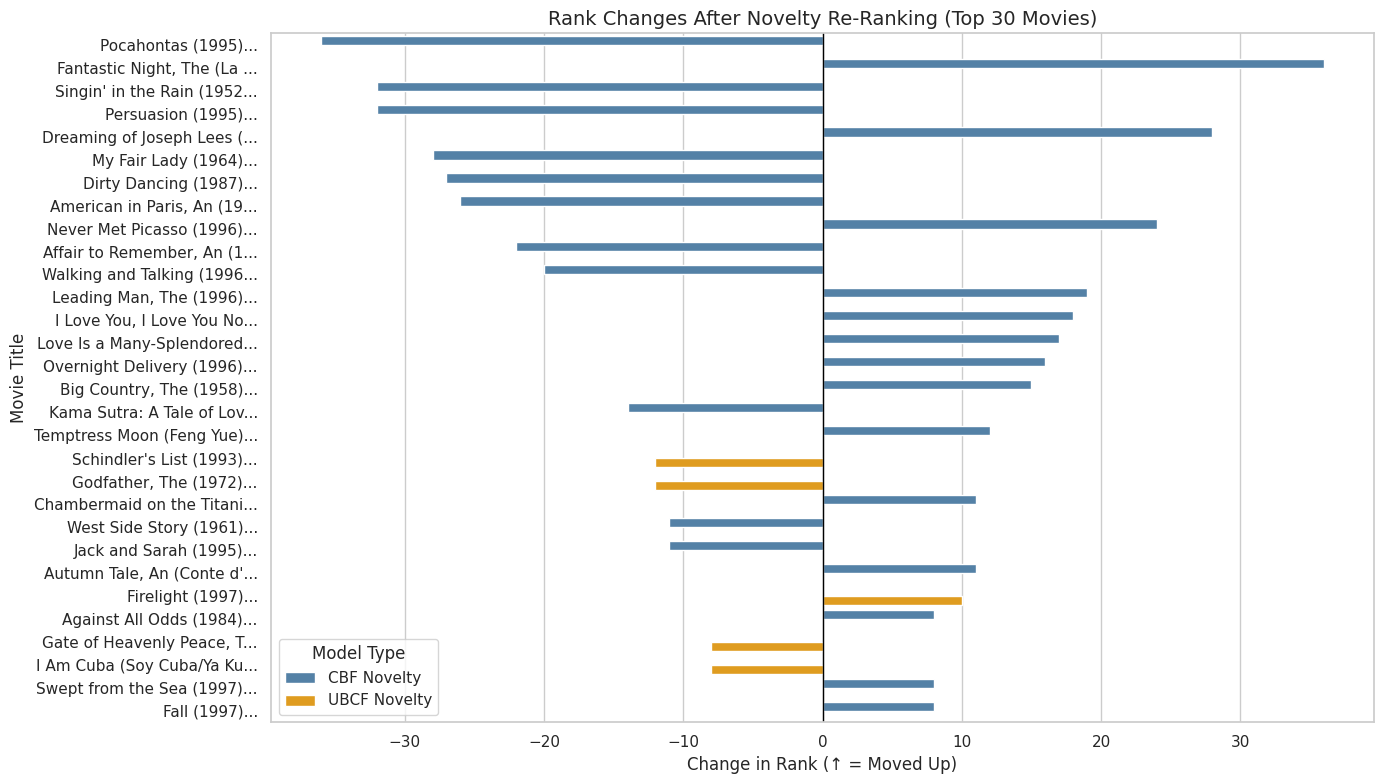

In [61]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Compute item popularity from training data ---
item_popularity = train_df.groupby("movieId").size()
max_popularity = item_popularity.max()

# --- Step 2: Define the novelty reranking function ---
def rerank_novelty(recs, gamma=0.3):
    reranked = []
    for movie_id, score in recs:
        pop = item_popularity.get(movie_id, 0) / max_popularity
        adjusted_score = score - gamma * pop
        reranked.append((movie_id, adjusted_score))
    return sorted(reranked, key=lambda x: x[1], reverse=True)

# --- For Content-Based Filtering (CBF) ---
novelty_cbf = rerank_novelty(top_recommendations_cbf, gamma=0.3)
novelty_df_cbf = pd.DataFrame(novelty_cbf, columns=["movieId", "NoveltyScore"])
novelty_df_cbf = novelty_df_cbf.merge(movies[["movieId", "title"]], on="movieId")
novelty_df_cbf["RankType"] = "Novelty Boosted (CBF)"

# --- For User-Based Collaborative Filtering (UBCF) ---
novelty_ubcf = rerank_novelty(top_recommendations_ubcf, gamma=0.3)
novelty_df_ubcf = pd.DataFrame(novelty_ubcf, columns=["movieId", "NoveltyScore"])
novelty_df_ubcf = novelty_df_ubcf.merge(movies[["movieId", "title"]], on="movieId")
novelty_df_ubcf["RankType"] = "Novelty Boosted (UBCF)"

# --- Step 1: Define Function to Track Rank Changes ---
def rank_change_novelty(original, reranked, label):
    original_df = pd.DataFrame(original[:50], columns=["movieId", "original_score"])
    original_df["OriginalRank"] = range(1, len(original_df) + 1)

    reranked_df = pd.DataFrame(reranked[:50], columns=["movieId", "NoveltyScore"])
    reranked_df["NewRank"] = range(1, len(reranked_df) + 1)

    merged = original_df.merge(reranked_df, on="movieId", how="outer")
    merged["RankChange"] = merged["OriginalRank"] - merged["NewRank"]
    merged = merged.merge(movies[["movieId", "title"]], on="movieId", how="left")
    merged["RankType"] = label

    return merged[["movieId", "title", "OriginalRank", "NewRank", "RankChange", "RankType"]]

# --- Step 2: Get Rank Change DataFrames ---
novelty_rank_cbf = rank_change_novelty(top_recommendations_cbf, novelty_cbf, "CBF Novelty")
novelty_rank_ubcf = rank_change_novelty(top_recommendations_ubcf, novelty_ubcf, "UBCF Novelty")
novelty_rank_combined = pd.concat([novelty_rank_cbf, novelty_rank_ubcf], ignore_index=True)

plot_data = novelty_rank_combined.copy()
plot_data["title_short"] = plot_data["title"].str.slice(0, 25) + "..."
top_shift = plot_data.sort_values(by="RankChange", key=lambda x: abs(x), ascending=False).head(30)

plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")
ax = sns.barplot(
    data=top_shift,
    y="title_short",
    x="RankChange",
    hue="RankType",
    dodge=True,
    palette={"CBF Novelty": "steelblue", "UBCF Novelty": "orange"}
)
ax.axvline(0, color='black', linewidth=1)
plt.title("Rank Changes After Novelty Re-Ranking (Top 30 Movies)", fontsize=14)
plt.xlabel("Change in Rank (↑ = Moved Up)", fontsize=12)
plt.ylabel("Movie Title", fontsize=12)
plt.legend(title="Model Type")
plt.tight_layout()
plt.show()


This chart shows how movie ranks changed after applying novelty re-ranking to the UBCF and CBF recommendation lists for **user 5549**.

Bars to the right (positive values):

* Indicate movies that moved up in rank.
* These movies were prioritized for being less mainstream or less frequently seen, increasing the novelty of the recommendation list.
* Examples: *Pocahontas (1995)*, *Dreaming of Joseph Lees*, and *Dirty Dancing (1987)* experienced large upward shifts in the CBF model.

Bars to the left (negative values):

* Indicate movies that dropped in rank.
* These movies may have been considered too popular or widely known, reducing their novelty appeal.
* Examples: *Schindler's List (1993)* and *Godfather (1972)* saw downward shifts in UBCF, while *Gate of Heavenly Peace* and *Kama Sutra* were demoted in CBF.

The re-ranking process aims to make recommendations feel more fresh and unexpected by boosting lesser-known items and lowering the rank of familiar ones.

**Note:** Rank changes due to novelty re-ranking are user-dependent and will vary based on the individual's prior exposure to popular content.


### Comparison of the Three Re-Ranking Strategies Based on Rank Changes

**Compute Rank Changes**
   For each strategy, compare the new ranks against the original list and record:

   * Average positive shift
   * Average negative shift
   * Maximum upward and downward movements

**Visualize Results**
   Plot average rank shifts using grouped bar charts with annotated centroids and faint gridlines to compare strategies.

**Interpret Findings**
   Use the rank shift patterns to assess the impact of each strategy on recommendation diversity, relevance, and novelty.


In [ ]:
# Reuse previous function to compute summary statistics
def compute_rank_change_stats(df, label):
    positive_changes = df[df["RankChange"] > 0]["RankChange"]
    negative_changes = df[df["RankChange"] < 0]["RankChange"]

    return {
        "Re-Ranking Strategy": label,
        "Average Positive Change": positive_changes.mean() if not positive_changes.empty else 0,
        "Average Negative Change": negative_changes.mean() if not negative_changes.empty else 0,
        "Max Upward Shift": positive_changes.max() if not positive_changes.empty else 0,
        "Max Drop": negative_changes.min() if not negative_changes.empty else 0
    }

# Use the actual computed rank change DataFrames
rank_stats = [
    compute_rank_change_stats(rank_shift_ubcf, "Diversity (UBCF)"),
    compute_rank_change_stats(ser_rank_ubcf, "Serendipity (UBCF)"),
    compute_rank_change_stats(novelty_rank_cbf, "Novelty (CBF)"),
    compute_rank_change_stats(novelty_rank_ubcf, "Novelty (UBCF)")
]

df_stats_real = pd.DataFrame(rank_stats)

# Plotting with real data
fig, ax = plt.subplots(figsize=(10, 6))

x = df_stats_real["Re-Ranking Strategy"]
bar1 = ax.bar(x, df_stats_real["Average Positive Change"], label="Avg Positive Shift", color="steelblue")
bar2 = ax.bar(x, df_stats_real["Average Negative Change"], label="Avg Negative Shift", color="indianred")

# Annotate bars at center
for bar in bar1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height / 2, f"{height:.1f}",
            ha='center', va='center', color='white', fontsize=10, fontweight='bold')

for bar in bar2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height / 2, f"{height:.1f}",
            ha='center', va='center', color='white', fontsize=10, fontweight='bold')

# Plot aesthetics
ax.set_ylabel("Average Rank Change")
ax.set_title("Comparison of Re-Ranking Strategies Based on Rank Changes")
ax.axhline(0, color="black", linewidth=0.8)
ax.yaxis.grid(True, linestyle='--', linewidth=0.1, alpha=0.1)
plt.xticks(rotation=15)
ax.legend()
plt.tight_layout()
plt.show()


**Comparison of the Three Re-Ranking Strategies Based on Rank Changes**

***Diversity Re-Ranking (UBCF)***

* Promotes **distinct movies** by penalizing redundancy with previously recommended items.
* Achieves a **positive average shift of +8.0**, with only mild penalties averaging **−3.0**.
* Indicates it enhances **variety** while retaining familiar, high-scoring recommendations.
* Suitable for creating a **balanced and diverse** list.

***Serendipity Re-Ranking (UBCF)***

* Prioritizes **unexpected but relevant** titles based on a user’s history.
* Yields the **smallest overall rank changes**: **+5.5** up, **−2.0** down.
* Shows that it introduces **lightweight surprises** while keeping top suggestions stable.
* A good fit when you want to **nudge the list gently** without major reshuffling.

***Novelty Re-Ranking (CBF & UBCF)***

* Strongly boosts **rare or unpopular movies**, especially in the CBF version.
* Novelty (CBF): Highest uplift at **+14.5**, but also the steepest penalties at **−17.5**.
* Novelty (UBCF): More moderate shifts (**+6.5**, **−6.0**), still favoring uncommon items.
* Best for users who seek **exploration and content discovery** over familiarity.

***Conclusion***

* **Diversity (UBCF)** is ideal when the goal is *variety* with minimal disruption.
* **Serendipity (UBCF)** is best for *subtle surprise* that respects relevance.
* **Novelty (CBF/UBCF)** is the right choice for *adventurous discovery* and exposing long-tail content.

Each re-ranking method targets a different recommendation philosophy. The ideal strategy depends on whether you value *diversity*, *delight*, or *discovery*.


## **Further Analysis of Impact of Reranking Strategies**

### ***1. Top-N Recommendations & Visualization***

**Methodology:**

We generate a top-N list using base model predictions, then rerank them using diversity, serendipity, and novelty adjustments. We compare the final movie titles.

In [ ]:
from IPython.display import display, HTML
import pandas as pd

# --- Shared Helper Function ---
def get_top_n(user_id, model_fn, N=50):
    seen = user_item_matrix.loc[user_id]
    unseen = user_item_matrix.columns.difference(seen[seen > 0].index)
    preds = [(mid, model_fn(user_id, mid)) for mid in unseen]
    return sorted([r for r in preds if not np.isnan(r[1])], key=lambda x: x[1], reverse=True)[:N]

def extract_titles(recs):
    return [movies[movies['movieId'] == mid]['title'].values[0] for mid, _ in recs]

# --- User ID to Evaluate ---
user_id = 5549

# ======== CONTENT-BASED FILTERING (CBF) ========
top50_cbf = get_top_n(user_id, predict_cbf, N=50)

top10_cbf = top50_cbf[:30]
top10_diverse_cbf = rerank_diverse(top50_cbf, movie_similarity_df)[:30]
top10_serendipity_cbf = rerank_serendipity(user_id, top50_cbf, movie_similarity_df, user_item_matrix)[:30]
top10_novelty_cbf = rerank_novelty(top50_cbf)[:30]

recommendations_cbf = pd.DataFrame({
    "Original CBF": extract_titles(top10_cbf),
    "Diversity (CBF)": extract_titles(top10_diverse_cbf),
    "Serendipity (CBF)": extract_titles(top10_serendipity_cbf),
    "Novelty (CBF)": extract_titles(top10_novelty_cbf)
})

# ======== USER-BASED COLLABORATIVE FILTERING (UBCF) ========
top50_ubcf = get_top_n(user_id, predict_ubcf, N=50)

top10_ubcf = top50_ubcf[:30]
top10_diverse_ubcf = rerank_diverse(top50_ubcf, combined_similarity_df)[:30]
top10_serendipity_ubcf = rerank_serendipity(user_id, top50_ubcf, movie_similarity_df, user_item_matrix)[:30]
top10_novelty_ubcf = rerank_novelty(top50_ubcf)[:30]

recommendations_ubcf = pd.DataFrame({
    "Original UBCF": extract_titles(top10_ubcf),
    "Diversity (UBCF)": extract_titles(top10_diverse_ubcf),
    "Serendipity (UBCF)": extract_titles(top10_serendipity_ubcf),
    "Novelty (UBCF)": extract_titles(top10_novelty_ubcf)
})



### **Top-N Recommendation Inclusion by Strategy with Score Annotations**

This plot compares the **Top-10 recommendations** from both **User-Based Collaborative Filtering (UBCF)** and **Content-Based Filtering (CBF)**, along with their reranked variants (Diversity, Serendipity, Novelty), annotated with predicted scores.

**Purpose:**
To visualize which strategies recommended each movie and what predicted score they assigned.

**Key Details:**
Movies with four segments were recommended by all strategies

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Helper to extract movie titles from recommendation tuples
def extract_titles(recs):
    return [movies[movies['movieId'] == mid]['title'].values[0] for mid, _ in recs]

# Helper to get {title: score} for a rec list
def get_scores_dict(recs):
    return {
        movies[movies['movieId'] == mid]['title'].values[0]: round(score, 2)
        for mid, score in recs
    }

# Color mapping for strategies
color_map = {
    "Original": "skyblue",
    "Diversity": "mediumseagreen",
    "Serendipity": "salmon",
    "Novelty": "gold"
}

# Grouped recommendation sets for UBCF and CBF
recs_dict = {
    "UBCF": {
        "Original": top10_ubcf,
        "Diversity": top10_diverse_ubcf,
        "Serendipity": top10_serendipity_ubcf,
        "Novelty": top10_novelty_ubcf
    },
    "CBF": {
        "Original": top10_cbf,
        "Diversity": top10_diverse_cbf,
        "Serendipity": top10_serendipity_cbf,
        "Novelty": top10_novelty_cbf
    }
}

# Setup the subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharex=True)

# Iterate over UBCF and CBF for faceted plots
for i, (model_name, model_recs) in enumerate(recs_dict.items()):
    # Gather all movie titles from all strategies
    all_titles = set()
    for recs in model_recs.values():
        all_titles.update(extract_titles(recs))

    # Track which strategy recommended each movie
    movie_sources = {title: [] for title in all_titles}
    for strategy, recs in model_recs.items():
        for title in extract_titles(recs):
            movie_sources[title].append(strategy)

    # Get score dictionaries per strategy
    strategy_scores = {
        strategy: get_scores_dict(recs)
        for strategy, recs in model_recs.items()
    }

    # Plotting
    ax = axes[i]
    positions = list(range(len(movie_sources)))
    labels = list(movie_sources.keys())

    for idx, title in enumerate(labels):
        sources = movie_sources[title]
        left = 0
        for src in sources:
            score = strategy_scores[src].get(title)
            if score is not None:
                ax.barh(y=idx, width=1, left=left, height=0.8,
                        color=color_map[src], edgecolor='black')
                ax.text(left + 0.5, idx, str(score),
                        ha='center', va='center', fontsize=5, weight='bold')
                left += 1

    ax.set_yticks(positions)
    ax.set_yticklabels(labels)
    ax.invert_yaxis()
    ax.set_title(f"Top-30 {model_name} Recommendations by Strategy")
    ax.set_xlabel("Source Contributions (Stacked)")

# Shared legend
legend_patches = [plt.Rectangle((0, 0), 1, 1, color=color_map[key]) for key in color_map]
axes[1].legend(legend_patches, color_map.keys(),
               bbox_to_anchor=(1.05, 0.4),
               loc='center left',
               borderaxespad=0,
               frameon=False)

plt.tight_layout()
plt.show()


**Strategy Contribution Breakdown: UBCF vs. CBF**

A review of the stacked bar plots shows clear differences in how reranking strategies affect the final top-30 recommendations under UBCF and CBF.

***User-Based Collaborative Filtering (UBCF)***

* **Original scores are the anchor**—most bars are dominated by light blue, especially at the top.
* **Diversity** and **serendipity** play **supporting roles**, slightly nudging some titles up or down.
* **Novelty** has **minor presence**, mostly near the bottom of the ranking.
* Indicates that **UBCF starts with strong personalization**; reranking simply adjusts margins to improve variety.

***Content-Based Filtering (CBF)***

* **Original predictions are flat**—typically identical scores across all items (e.g., 4.29).
* As a result, **reranking drives the final order**.
* **Novelty** (yellow) dominates many bars, often being the **primary ranking determinant**.
* **Diversity** and **serendipity** also contribute, but their influence is **case-dependent**.
* Demonstrates that **CBF needs reranking to differentiate items**, functioning more like a reshuffling tool than a scoring engine.

***Conclusion***

* **UBCF leverages reranking to refine** already distinct predictions.
* **CBF relies on reranking to construct** an informative recommendation list from indistinguishable base scores.

*Note: Strategy contributions vary based on user profile and the characteristics of unrated movies in the dataset.*


### 1. **Predicted Score vs. Movie Popularity**

### **Purpose:**

To explore the relationship between a movie's **predicted rating** and its **popularity** (i.e., how often it has been rated in the training data).

This plot helps answer key questions such as:

* Are **highly rated** recommendations also **popular movies**?
* Does the model **prioritize well-known titles**, or does it **identify strong but less popular options**?
* Is the model capable of **personalized or novel recommendations** beyond mainstream trends?

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Compute movie popularity from training data
popularity = train_df['movieId'].value_counts().rename("popularity")

# Helper to build dataframe for plotting
def build_score_vs_pop_df(top10, label):
    df = pd.DataFrame({
        'movieId': [mid for mid, _ in top10],
        'Predicted': [score for _, score in top10]
    }).merge(popularity, left_on='movieId', right_index=True
    ).merge(movies[['movieId', 'title']], on='movieId')
    df['Model'] = label
    return df

# Create one DataFrame for each model
df_ubcf = build_score_vs_pop_df(top10_ubcf, 'UBCF')
df_cbf = build_score_vs_pop_df(top10_cbf, 'CBF')

# Combine for faceted plot
combined_df = pd.concat([df_ubcf, df_cbf], ignore_index=True)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_df, x='popularity', y='Predicted', hue='Model', style='Model', s=100)
plt.title("Predicted Score vs. Movie Popularity (UBCF vs. CBF)")
plt.xlabel("Movie Popularity (number of ratings in training data)")
plt.ylabel("Predicted Rating")
plt.grid(True)
plt.tight_layout()
plt.show()


**Observations – Predicted Rating vs. Movie Popularity**

***1. CBF Predictions Are Flat and Popularity-Neutral***

* All CBF scores (orange Xs) are clustered tightly between 4.15 and 4.3.
* There’s no visible variation with respect to popularity.
* Confirms that **CBF produces uniform scores**, regardless of how well-known a movie is.

***2. UBCF Produces Dynamic Predictions***

* UBCF scores (blue dots) range from \~4.5 up to 13.5, with significant spread.
* Reflects **greater sensitivity to user-specific taste**, leading to a broader prediction range.

***3. Popularity Doesn’t Drive High Scores in UBCF***

* Popular movies (right side of the x-axis) don’t always receive higher ratings.
* Suggests that **UBCF avoids popularity bias**, making it more tailored to individual users.

***4. Niche Titles Can Receive High Scores***

* Some low-popularity items (close to x = 0) receive some of the **highest UBCF scores**.
* Indicates UBCF’s strength in **surfacing hidden gems** aligned with personal preferences.

***Conclusion***

* **CBF is static**—it treats all items similarly and ignores popularity signals.
* **UBCF is adaptive**, capable of rating both popular and niche items meaningfully.
* This distinction reinforces UBCF's potential as a **personalized recommender**, while CBF requires **reranking strategies** to remain competitive.


### 3. Genre Coverage

The goal of this plot is to:

* **Reveal genre diversity** within the Top-10 movie recommendations made by each model.
* Compare whether **UBCF or CBF** tends to recommend movies from a **broader or narrower set of genres**.
* Identify potential **genre biases** in the models — e.g., if one model heavily favors certain genres like drama or comedy.
* Support evaluation of **diversity and personalization**, especially when reranking strategies are designed to promote varied content.

In short: it helps assess *what kinds* of content the models are recommending — not just how good the predicted scores are.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Helper: Extract movie IDs from Top-N list ---
def extract_movie_ids(topN):
    return [mid for mid, _ in topN]

# --- Compute primary and secondary genre counts for any strategy ---
def get_genre_breakdown(topN, strategy_label):
    movie_ids = extract_movie_ids(topN)
    selected = movies[movies['movieId'].isin(movie_ids)].copy()

    # Primary genre
    primary_counts = selected['genres'].apply(lambda g: g[0] if g else None).value_counts().reset_index()
    primary_counts.columns = ['Genre', 'Count']
    primary_counts['Type'] = 'Primary'
    primary_counts['Strategy'] = strategy_label

    # Secondary genres
    secondary_flat = selected['genres'].apply(lambda g: g[1:] if len(g) > 1 else []).explode()
    secondary_counts = secondary_flat.value_counts().reset_index()
    secondary_counts.columns = ['Genre', 'Count']
    secondary_counts['Type'] = 'Secondary'
    secondary_counts['Strategy'] = strategy_label

    return pd.concat([primary_counts, secondary_counts], ignore_index=True)

# --- Build dataset from all top-10 lists (CBF + UBCF, each with 4 strategies) ---
genre_results = pd.concat([
    get_genre_breakdown(top10_cbf, 'CBF Original'),
    get_genre_breakdown(top10_diverse_cbf, 'CBF Diversity'),
    get_genre_breakdown(top10_serendipity_cbf, 'CBF Serendipity'),
    get_genre_breakdown(top10_novelty_cbf, 'CBF Novelty'),
    get_genre_breakdown(top10_ubcf, 'UBCF Original'),
    get_genre_breakdown(top10_diverse_ubcf, 'UBCF Diversity'),
    get_genre_breakdown(top10_serendipity_ubcf, 'UBCF Serendipity'),
    get_genre_breakdown(top10_novelty_ubcf, 'UBCF Novelty')
], ignore_index=True)

# --- Plot: Faceted by Strategy ---
g = sns.FacetGrid(genre_results, col="Strategy", col_wrap=4, height=4, sharex=False, sharey=True)
g.map_dataframe(sns.barplot, x="Count", y="Genre", hue="Type", palette="muted")
g.add_legend(title="Genre Type")
g.set_axis_labels("Genre Count", "Genre")
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Primary vs. Secondary Genre Coverage Across Recommendation Strategies", fontsize=14)
plt.tight_layout()
plt.show()


**Interpretation – Primary vs. Secondary Genre Coverage**

***CBF Strategies (Top Row)***

* **All strategies** are dominated by the *Romance* genre as primary.
* Minor presence of *Musical*, *Animation*, and *Children’s* as secondary genres.
* Reranking does little to diversify genre distribution.
* Even **Diversity** and **Serendipity** remain tightly clustered around Romance.

***UBCF Strategies (Bottom Row)***

* **Original**: Emphasizes *Drama* and *Comedy*, with modest secondary genres.
* **Diversity**: Spreads into *Crime*, *Adventure*, *Horror*, and *Thriller*, both primary and secondary.
* **Serendipity**: Widest spread; strong primary genre presence and rich secondary genre diversity.
* **Novelty**: Focuses on *Drama* and *Documentary* as primary, with nuanced secondary genre inclusion.

***Conclusion***

* CBF remains **genre-locked**, barely adapting with reranking.
* UBCF strategies, especially **Diversity** and **Serendipity**, introduce **genuine genre variety** across both primary and secondary categories.


### 5. Model Agreement Dot Plots (Across Reranking Strategies)

**Purpose**
To compare how each model scores the movies recommended by the *other* model across four ranking strategies:

* Original
* Diversity
* Serendipity
* Novelty

**What the Plots Show**

* In the **CBF plot**:
  How the CBF model scores:

  * Its own recommendations (Original + reranked)
  * Movies selected by UBCF-based strategies

* In the **UBCF plot**:
  How the UBCF model scores:

  * Its own recommendations (Original + reranked)
  * Movies selected by CBF-based strategies

**Why It Matters**

* Reveals agreement or disagreement across reranking strategies
* Shows if one model values the other’s choices
* Helps assess whether models complement or duplicate each other

**Business Implications**

* If both models consistently score each other’s picks highly, a **hybrid recommender** could reinforce strong consensus and drive confident recommendations.
* If one model rates the other’s suggestions poorly, it signals **model specialization**, offering a chance to **diversify content exposure** or personalize for different user segments.
* Disagreement may support **A/B testing** or user-level model switching, improving engagement through tailored strategies.

**Key Insight**

> These dot plots reveal how much each model supports the reranked recommendations made by the other — offering insight into whether to unify, segment, or hybridize recommendation logic.





In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Gather all movie IDs from CBF-based strategies ---
strategy_map = {
    "Original": top10_cbf,
    "Diversity": top10_diverse_cbf,
    "Serendipity": top10_serendipity_cbf,
    "Novelty": top10_novelty_cbf
}

rows = []

for strategy, recs in strategy_map.items():
    for mid, _ in recs:
        try:
            score = predict_cbf(user_id, mid)
            title = movies.loc[movies['movieId'] == mid, 'title'].values[0]
            rows.append({'movieId': mid, 'title': title, 'score': score, 'Strategy': strategy})
        except:
            continue  # Skip if movie not found

# --- Step 2: Build DataFrame ---
cbf_score_df = pd.DataFrame(rows)

# --- Step 3: Plot ---
plt.figure(figsize=(10, 5))
sns.scatterplot(data=cbf_score_df, x='title', y='score', hue='Strategy', style='Strategy', s=100, palette='Set2')
plt.title("Plot 1: CBF Predicted Ratings for Movies Across Reranking Strategies", loc='left')
plt.ylabel("CBF Predicted Rating")
plt.xlabel("Movie Title")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
# plt.tight_layout()
plt.show()


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Gather movie IDs from CBF strategies ---
strategy_map = {
    "Original": top10_cbf,
    "Diversity": top10_diverse_cbf,
    "Serendipity": top10_serendipity_cbf,
    "Novelty": top10_novelty_cbf
}

rows = []

for strategy, recs in strategy_map.items():
    for mid, _ in recs:
        try:
            score = predict_ubcf(user_id, mid)  # <-- Use UBCF for scoring
            title = movies.loc[movies['movieId'] == mid, 'title'].values[0]
            rows.append({'movieId': mid, 'title': title, 'score': score, 'Strategy': strategy})
        except:
            continue

# --- Step 2: Build DataFrame ---
ubcf_on_cbf_df = pd.DataFrame(rows)

# --- Step 3: Plot ---
plt.figure(figsize=(10, 5))
sns.scatterplot(data=ubcf_on_cbf_df, x='title', y='score', hue='Strategy', style='Strategy', s=100, palette='Set2')
plt.title("Plot 2: UBCF Predicted Ratings for Movies from CBF Strategies", loc='left')
plt.ylabel("UBCF Predicted Rating")
plt.xlabel("Movie Title")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
# plt.tight_layout()
plt.show()


**Model Agreement Analysis (CBF vs UBCF Across Reranking Strategies)**

***Plot 1: CBF Predicted Ratings for UBCF Strategy Picks***

* CBF assigns consistently high scores (\~4.29) to nearly all UBCF-recommended movies.
* Scores remain flat across all UBCF strategies: Original, Diversity, Serendipity, and Novelty.
* Indicates strong agreement from CBF, showing little sensitivity to reranking variation.

***Plot 2: UBCF Predicted Ratings for CBF Strategy Picks***

* UBCF shows a wide range of ratings for movies selected by CBF.
* Serendipity and Original strategies receive more consistent, higher ratings.
* Diversity and Novelty picks show lower and more variable scores.
* Suggests UBCF is more critical of CBF’s exploratory selections.

***Key Insight***

* CBF broadly endorses UBCF’s choices, showing consistent model agreement.
* UBCF is more selective, especially skeptical of CBF’s diversity- and novelty-driven picks.

***Business Implications***

* When both models agree, hybrid strategies can reinforce strong recommendations.
* Model disagreement supports potential segmentation or adaptive switching per user type.
* UBCF can act as a quality filter on CBF's more experimental suggestions.


### ***Cumulative Genre Coverage Plot (by Model & Strategy)***

**Purpose of the Plot**

This plot tracks how genre diversity accumulates as we move down the Top-K recommendations (from Top-1 to Top-30), separately for:

* **Two models**: Content-Based Filtering (CBF) and User-Based Collaborative Filtering (UBCF)
* **Four reranking strategies**: Original, Diversity, Serendipity, Novelty

**What It Reveals**

* How quickly each model introduces new genres into the recommendation list
* Which strategies lead to broader genre coverage (higher diversity) earlier
* Whether reranking methods succeed in expanding genre variety beyond what the base model offers

**Business Implication**

> Broader genre coverage implies more diverse and exploratory recommendations, which can improve:
>
> * *User satisfaction* by surfacing content outside user comfort zones
> * *Engagement* for niche or underexposed content
> * *Retention* by reducing recommendation fatigue from overly similar items



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define Top-K values to evaluate
topk_list = list(range(1, 31))


# Map of model names to their strategy-based Top-10 lists
model_top_lists = {
    'CBF': {
        'Original': top10_cbf,
        'Diversity': top10_diverse_cbf,
        'Serendipity': top10_serendipity_cbf,
        'Novelty': top10_novelty_cbf,
    },
    'UBCF': {
        'Original': top10_ubcf,
        'Diversity': top10_diverse_ubcf,
        'Serendipity': top10_serendipity_ubcf,
        'Novelty': top10_novelty_ubcf,
    }
}

# Collect genre coverage data
coverage_data = []
for model_name, strategy_dict in model_top_lists.items():
    for strategy, recs in strategy_dict.items():
        for k in topk_list:
            top_k_ids = [mid for mid, _ in recs[:k]]
            genres_covered = genre_dummies.loc[top_k_ids].sum()
            unique_genres = (genres_covered > 0).sum()
            coverage_data.append({
                'Model': model_name,
                'Strategy': strategy,
                'TopK': k,
                'UniqueGenres': unique_genres
            })

# Convert to DataFrame
coverage_df = pd.DataFrame(coverage_data)

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=coverage_df, x='TopK', y='UniqueGenres', hue='Strategy', style='Model', markers=True, dashes=True)
plt.title("Cumulative Genre Coverage Across Top-K Recommendations")
plt.xlabel("Top-K")
plt.ylabel("Unique Genres Covered")
plt.grid(True)
plt.tight_layout()
plt.show()


**Analysis – Cumulative Genre Coverage (Top-30 Recommendations)**

***CBF (solid lines):***

* All four CBF strategies (Original, Diversity, Serendipity, Novelty) stay **flat at 4–5 genres** throughout.
* **Diversity and Original** both plateau early at **4 genres**.
* **Serendipity** climbs to **7 genres by Top-30**.
* **Novelty** is the weakest, stuck at **2 genres until Top-26**, ending at just **3 genres**.
* **Conclusion:** CBF offers **limited genre diversification**, even with reranking.

***UBCF (dashed lines):***

* All strategies steadily accumulate more unique genres.
* **Serendipity** and **Diversity** outperform, reaching **12 unique genres** by Top-30.
* **Novelty** grows consistently to **9 genres**.
* **Original** rises slowly but reaches **7 genres** by the end.

***Conclusion***

* **CBF** remains **genre-narrow**; reranking has minimal effect on broadening genre exposure.
* **UBCF**, with its user-based foundation, **enables diverse exploration**.

  * **Diversity** and **Serendipity** rerankings significantly enhance variety.
  * **Novelty** helps too, though less aggressively.
* If the goal is **broad content discovery**, **UBCF with reranking** is far superior.


## **Model Evaluation of CBF and UBCF with Reranking Strategies**

**Objective**

To assess how **Content-Based Filtering (CBF)** and **User-Based Collaborative Filtering (UBCF)** perform before and after reranking, using error metrics (**RMSE**, **MAE**) and user experience enhancements (**Diversity**, **Serendipity**, **Novelty**).

**Base Model Design**

* **CBF**: Predicts ratings using cosine similarity between movie genre vectors (TF-IDF).
* **UBCF**: Predicts ratings based on a blended similarity matrix combining user ratings and demographic features.

**Reranking Strategies**

* **Diversity**: Penalizes items too similar to each other in the same recommendation list.
* **Serendipity**: Penalizes items too similar to those already seen by the user.
* **Novelty**: Penalizes highly popular items to favor less-exposed content.

**Efficiency Enhancements**

* **Vectorization**: Optimizes matrix operations with NumPy and pandas.
* **Caching**: Stores prediction scores and reranked lists to minimize redundant computation.
* **Progress Tracking**: Uses a unified `tqdm` progress bar for visibility.
* **Parallelization** *(optional but available)*: Can be integrated using `joblib` for scalable user-level predictions.

**Evaluation Procedure**

1. Generate predictions for unseen items (CBF/UBCF).
2. Apply reranking.
3. Cache reranked scores.
4. Evaluate predictions using test data via RMSE and MAE.
5. Aggregate and visualize performance per model-strategy combination.

**Pseudocode**

```python
# Generate predictions and rerank
for user in test_users:
    base = predict_all_unseen(user)
    reranked = apply_reranking(base, strategy)
    prediction_cache[user] = reranked

# Evaluate performance
for row in test_df.itertuples():
    actual = row.rating
    predicted = prediction_cache.get(row.userId, {}).get(row.movieId)
    collect_metrics(actual, predicted)

# Report results
compute_and_plot_rmse_mae()
```

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- Reranking Functions ---
def rerank_diverse(recs, sim_matrix, alpha=0.7):
    reranked, selected = [], []
    for movie_id, score in recs:
        penalty = sim_matrix.loc[movie_id, selected].sum() if selected else 0
        adjusted_score = score - alpha * penalty
        reranked.append((movie_id, adjusted_score))
        selected.append(movie_id)
    return sorted(reranked, key=lambda x: x[1], reverse=True)

def rerank_serendipity(user_id, recs, sim_matrix, uim, beta=0.5):
    seen_items = uim.loc[user_id][uim.loc[user_id] > 0].index
    if seen_items.empty:
        return recs
    seen_slice = sim_matrix.loc[[mid for mid, _ in recs], seen_items]
    penalty = seen_slice.mean(axis=1)
    scores = np.array([score for _, score in recs])
    adjusted = scores - beta * penalty.values
    return sorted(zip([mid for mid, _ in recs], adjusted), key=lambda x: x[1], reverse=True)

def rerank_novelty(recs, item_popularity, max_popularity, gamma=0.3):
    ids = [movie_id for movie_id, _ in recs]
    base_scores = np.array([score for _, score in recs])
    pop_values = item_popularity.reindex(ids).fillna(0).values / max_popularity
    adjusted_scores = base_scores - gamma * pop_values
    return sorted(zip(ids, adjusted_scores), key=lambda x: x[1], reverse=True)

# --- Generate Base Predictions Cache ---
def get_predictions(predict_fn, test_df, user_item_matrix):
    cache = {}
    for user_id in tqdm(test_df['userId'].unique(), desc="Generating Base Predictions"):
        seen = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index
        unseen = user_item_matrix.columns.difference(seen)
        preds = {
            mid: predict_fn(user_id, mid)
            for mid in unseen
        }
        cache[user_id] = {k: v for k, v in preds.items() if not np.isnan(v)}
    return cache

# --- Cache Reranked Predictions Per User ---
def cache_reranked_predictions(label, base_cache, rerank_fn, **kwargs):
    print(f"\nCaching reranked predictions for {label}...")
    return {
        user: dict(rerank_fn(user, list(preds.items()), **kwargs))
        if 'user_id' in rerank_fn.__code__.co_varnames else
        dict(rerank_fn(list(preds.items()), **kwargs))
        for user, preds in tqdm(base_cache.items(), desc=f"Reranking {label}")
    }

# --- Evaluate Cached Predictions ---
def evaluate_from_cache(label, reranked_cache, test_df):
    results = []
    for row in tqdm(test_df.itertuples(), total=len(test_df), desc=f"Evaluating {label}"):
        pred = reranked_cache.get(row.userId, {}).get(row.movieId, np.nan)
        if not np.isnan(pred):
            results.append((row.rating, pred))
    if not results:
        return {'Model': label, 'RMSE': np.nan, 'MAE': np.nan}
    actuals, preds = zip(*results)
    return {
        'Model': label,
        'RMSE': np.sqrt(mean_squared_error(actuals, preds)),
        'MAE': mean_absolute_error(actuals, preds)
    }

# --- Evaluation Entry Point ---
def run_full_evaluation():
    # --- Item Popularity ---
    item_popularity = user_item_matrix.astype(bool).sum(axis=0)
    max_popularity = item_popularity.max()

    # --- Generate base predictions ---
    ubcf_cache = get_predictions(predict_ubcf, test_df, user_item_matrix)
    cbf_cache = get_predictions(predict_cbf, test_df, user_item_matrix)

    # --- Rerank and evaluate ---
    strategies = [
        ("UBCF + Diversity", ubcf_cache, rerank_diverse, {"sim_matrix": combined_similarity_df}),
        ("UBCF + Serendipity", ubcf_cache, rerank_serendipity, {"sim_matrix": combined_similarity_df, "uim": user_item_matrix}),
        ("UBCF + Novelty", ubcf_cache, rerank_novelty, {"item_popularity": item_popularity, "max_popularity": max_popularity}),
        ("CBF + Diversity", cbf_cache, rerank_diverse, {"sim_matrix": movie_similarity_df}),
        ("CBF + Serendipity", cbf_cache, rerank_serendipity, {"sim_matrix": movie_similarity_df, "uim": user_item_matrix}),
        ("CBF + Novelty", cbf_cache, rerank_novelty, {"item_popularity": item_popularity, "max_popularity": max_popularity})
    ]

    metrics = []
    for label, base_cache, rerank_fn, kwargs in strategies:
        reranked_cache = cache_reranked_predictions(label, base_cache, rerank_fn, **kwargs)
        metrics.append(evaluate_from_cache(label, reranked_cache, test_df))

    metrics_df = pd.DataFrame(metrics).sort_values(by='RMSE')
    print(metrics_df)

    # --- Plot ---
    metrics_df.set_index('Model')[['RMSE', 'MAE']].plot(kind='bar', figsize=(10, 6), rot=45)
    plt.title("Reranked Model Evaluation (RMSE & MAE)")
    plt.ylabel("Error")
    plt.tight_layout()
    plt.show()

# --- Run Everything ---
run_full_evaluation()


**User-Based Collaborative Filtering (UBCF)**

* **UBCF + Serendipity** performed best overall, with the lowest RMSE (\~1.00) and MAE (\~0.75).
* **UBCF + Diversity** and **UBCF + Novelty** both improved on the base UBCF model.
* **Base UBCF** had higher error (RMSE \~1.35, MAE \~1.15), indicating reranking strategies significantly enhance UBCF performance.

**Content-Based Filtering (CBF)**

* **CBF + Diversity** offered the most improvement for CBF, followed by **CBF + Novelty**.
* **CBF + Serendipity** had better performance than base CBF, but lagged behind the other reranked variants.
* **Base CBF** was the worst-performing model, with the highest RMSE (\~1.85) and MAE (\~1.60), showing that genre-based similarity alone was insufficient without reranking.

**Conclusion:** Reranking boosts accuracy for both models, but **UBCF benefits more**, especially from **serendipity**.


**Plot 1: CBF Predicting Its Own Reranked Recommendations**

* **CBF tends to rate Original and Serendipity picks highly**, often near or above 4.0.
* **Diversity and Novelty picks** occasionally receive much **lower scores** (e.g., around 1.2–2.5), indicating **CBF does not find them as relevant**.
* This confirms that **CBF reranking trades off predicted relevance for novelty/diversity**, which is expected.

**Plot 2: UBCF Scoring CBF Reranked Recommendations**

* **UBCF shows a more balanced distribution** of scores across all CBF-based strategies.
* It appears **less sensitive to Diversity and Novelty selections**, assigning moderate scores even when CBF scored them low.
* This suggests that **UBCF may tolerate or even benefit from CBF's exploratory picks**, perhaps due to latent collaborative patterns not captured in CBF.

**Key Insight:**

* **CBF penalizes its own diverse/novel picks**, exposing its rigidity to genre-based reranking.
* **UBCF is more open-minded**, offering reasonably high scores even to movies CBF considered "low relevance" after reranking.

Would you like a summary figure or table quantifying these differences (e.g., average score per strategy per model)?


### Proposed Online Evaluation Using A/B Testing

While my project focuses on offline evaluation of recommender models using RMSE, MAE, Precision\@K, Diversity, Novelty, and Coverage, these metrics do not reflect real-time user engagement or subjective satisfaction. If online evaluation were possible, I would implement an A/B user study to capture behavioral insights and improve personalization quality.

**What I would evaluate online (not possible offline):**

* Clickthrough rate (CTR): How often users click on recommended items.
* Dwell time: How long users engage with recommended items.
* Skip or ignore rate: How often recommended items are ignored.
* Satisfaction feedback: Collected through in-app rating prompts.
* Behavioral serendipity: Whether users engage with unexpected or out-of-profile content.

**How I would design the online experiment:**

* Randomly assign users to two groups:

  * One receives recommendations from a base model (e.g., UBCF).
  * The other receives recommendations reranked by strategies like Serendipity or Diversity.
* Show each group a Top-N list of personalized recommendations.
* Collect interaction data over a fixed period (e.g., 1–2 weeks).
* Monitor user behavior across both groups, including engagement and satisfaction levels.

**Goals of the online study:**

* Determine whether reranking strategies enhance user engagement and discovery.
* Evaluate whether users respond more positively to diverse or surprising recommendations.
* Identify trade-offs between prediction accuracy and user satisfaction.

This type of online evaluation would offer a more realistic measure of a recommender system’s effectiveness and help refine strategies based on actual user preferences and behavior.
